# Comparing performance by training only with "relevant" features (informed by permutation and feature importance) and the complete training dataset.

> This notebook builds on the work of all the Fast-Tabulous team. Thanks to Michael, Nissan, Owen, Tim, and Tracy. The notebook compares the results of different models (FastAI, XGBoost, random forest) when trained with all the data and trained with the most "relevant" features. When reducing the amount of training data to only the most "relevant" columns, we have a pretty close performance compared to when all the columns were used to train the models. The next step will be to optimise the models (via Optuna/GridSearch or other methods) and find out if we have better results with only the "relevant" features/columns. According to the current results, we may reduce the processing time and create synthetic data to test the end-product prototype (perhaps having a real-time demo?).

- toc: true
- badges: true
- comments: true
- author: Jorge
- image: images/chart-preview

A quick view of the results in case you don't want to go through the whole notebook, lol.
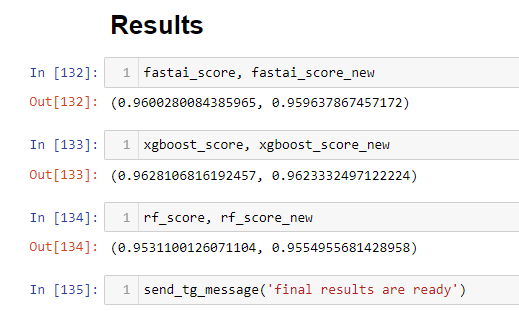

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random as rd
import requests

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

path = 'C:/Users/ML/PycharmProjects/fastai/data/'

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

#### Auxiliary functions

In [2]:
# Telegram bot details
tg_api_token = '***'
tg_chat_id = '***'

def send_tg_message(message):
    requests.post(
        'https://api.telegram.org/' +
        'bot{}/sendMessage'.format(tg_api_token), 
        params=dict(chat_id=tg_chat_id, text=message)
    )

In [3]:
def drop_cols_from_list(df,cols_to_delete):
    df.drop(cols_to_delete,axis=1,inplace=True)
    return df

# Dataset exploration

Visualise, clean and play a bit around with the data.

In [4]:
train_df = pd.read_csv(path + 'train.csv', low_memory=False)
test_df = pd.read_csv(path + 'test.csv', low_memory=False)

In [5]:
train_df

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,...,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,1,2013-08-16,0,B,...,-1,10,N,CA
1,2,2014-04-22,0,F,...,-1,20,N,NJ
2,4,2014-08-25,0,F,...,-1,8,N,NJ
3,6,2013-04-15,0,J,...,-1,21,N,TX
4,8,2014-01-25,0,E,...,-1,12,N,IL
...,...,...,...,...,...,...,...,...,...
260748,434584,2013-05-16,0,J,...,-1,8,N,TX
260749,434585,2014-12-07,0,J,...,-1,20,N,TX
260750,434586,2014-02-18,0,F,...,-1,8,N,NJ
260751,434587,2014-04-08,0,F,...,-1,16,N,NJ


#### Check if there are NaN values in the training set

In [6]:
# check the total number of NaN values
train_df.isna().sum().sum()

326623

In [7]:
# Get the name of the columns were we have NaN values
train_df.isna().sum()[train_df.isna().sum() > 0].index

Index(['PersonalField7', 'PersonalField84', 'PropertyField3', 'PropertyField4',
       'PropertyField29', 'PropertyField32', 'PropertyField34',
       'PropertyField36', 'PropertyField38'],
      dtype='object')

In [8]:
train_df.PersonalField7.unique()

array(['N', 'Y', nan], dtype=object)

In [9]:
train_df.PersonalField7.isna().unique()

array([False,  True])

In [10]:
# Get the number of NaNs
train_df.PersonalField7.isna().sum()

113

In [11]:
# An experiment to see what happens if we drop the rows that have NaN values
train_df.dropna(subset=['PersonalField7', 'PersonalField84', 'PropertyField3', 'PropertyField4', 'PropertyField29',
                         'PropertyField32', 'PropertyField34', 'PropertyField36', 'PropertyField38'], inplace=False)

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,...,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,1,2013-08-16,0,B,...,-1,10,N,CA
4,8,2014-01-25,0,E,...,-1,12,N,IL
6,13,2013-11-01,0,J,...,-1,8,N,TX
11,22,2013-06-11,0,B,...,-1,8,N,CA
19,37,2013-06-18,0,E,...,-1,8,N,IL
...,...,...,...,...,...,...,...,...,...
260737,434569,2014-03-10,0,E,...,-1,25,N,IL
260738,434571,2014-04-11,0,E,...,-1,10,N,IL
260743,434579,2013-05-02,0,B,...,-1,17,N,CA
260744,434580,2013-10-28,0,F,...,-1,19,N,NJ


We will just drop the columns that have NaN values as we would have significant less data if we drop the rows that contain NaN values.

#### This section will delete the columns that have NaN values

In [12]:
cols_to_delete = train_df.isna().sum()[train_df.isna().sum() > 0].index

train_df1 = drop_cols_from_list(train_df,cols_to_delete)
test_df1 = drop_cols_from_list(test_df,cols_to_delete)

In [13]:
train_df1

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,...,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,1,2013-08-16,0,B,...,-1,10,N,CA
1,2,2014-04-22,0,F,...,-1,20,N,NJ
2,4,2014-08-25,0,F,...,-1,8,N,NJ
3,6,2013-04-15,0,J,...,-1,21,N,TX
4,8,2014-01-25,0,E,...,-1,12,N,IL
...,...,...,...,...,...,...,...,...,...
260748,434584,2013-05-16,0,J,...,-1,8,N,TX
260749,434585,2014-12-07,0,J,...,-1,20,N,TX
260750,434586,2014-02-18,0,F,...,-1,8,N,NJ
260751,434587,2014-04-08,0,F,...,-1,16,N,NJ


In [14]:
train_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260753 entries, 0 to 260752
Columns: 290 entries, QuoteNumber to GeographicField64
dtypes: float64(4), int64(265), object(21)
memory usage: 576.9+ MB


In [15]:
# duble-check that we don't have any NaN values
vld = train_df1.isna().sum()>0
vld.unique()

array([False])

#### Visualise the class-distribution of the training set

In [16]:
labels = train_df.QuoteConversion_Flag.value_counts()
labels

0    211859
1     48894
Name: QuoteConversion_Flag, dtype: int64

Text(0.5, 1.0, '2-class label distribution')

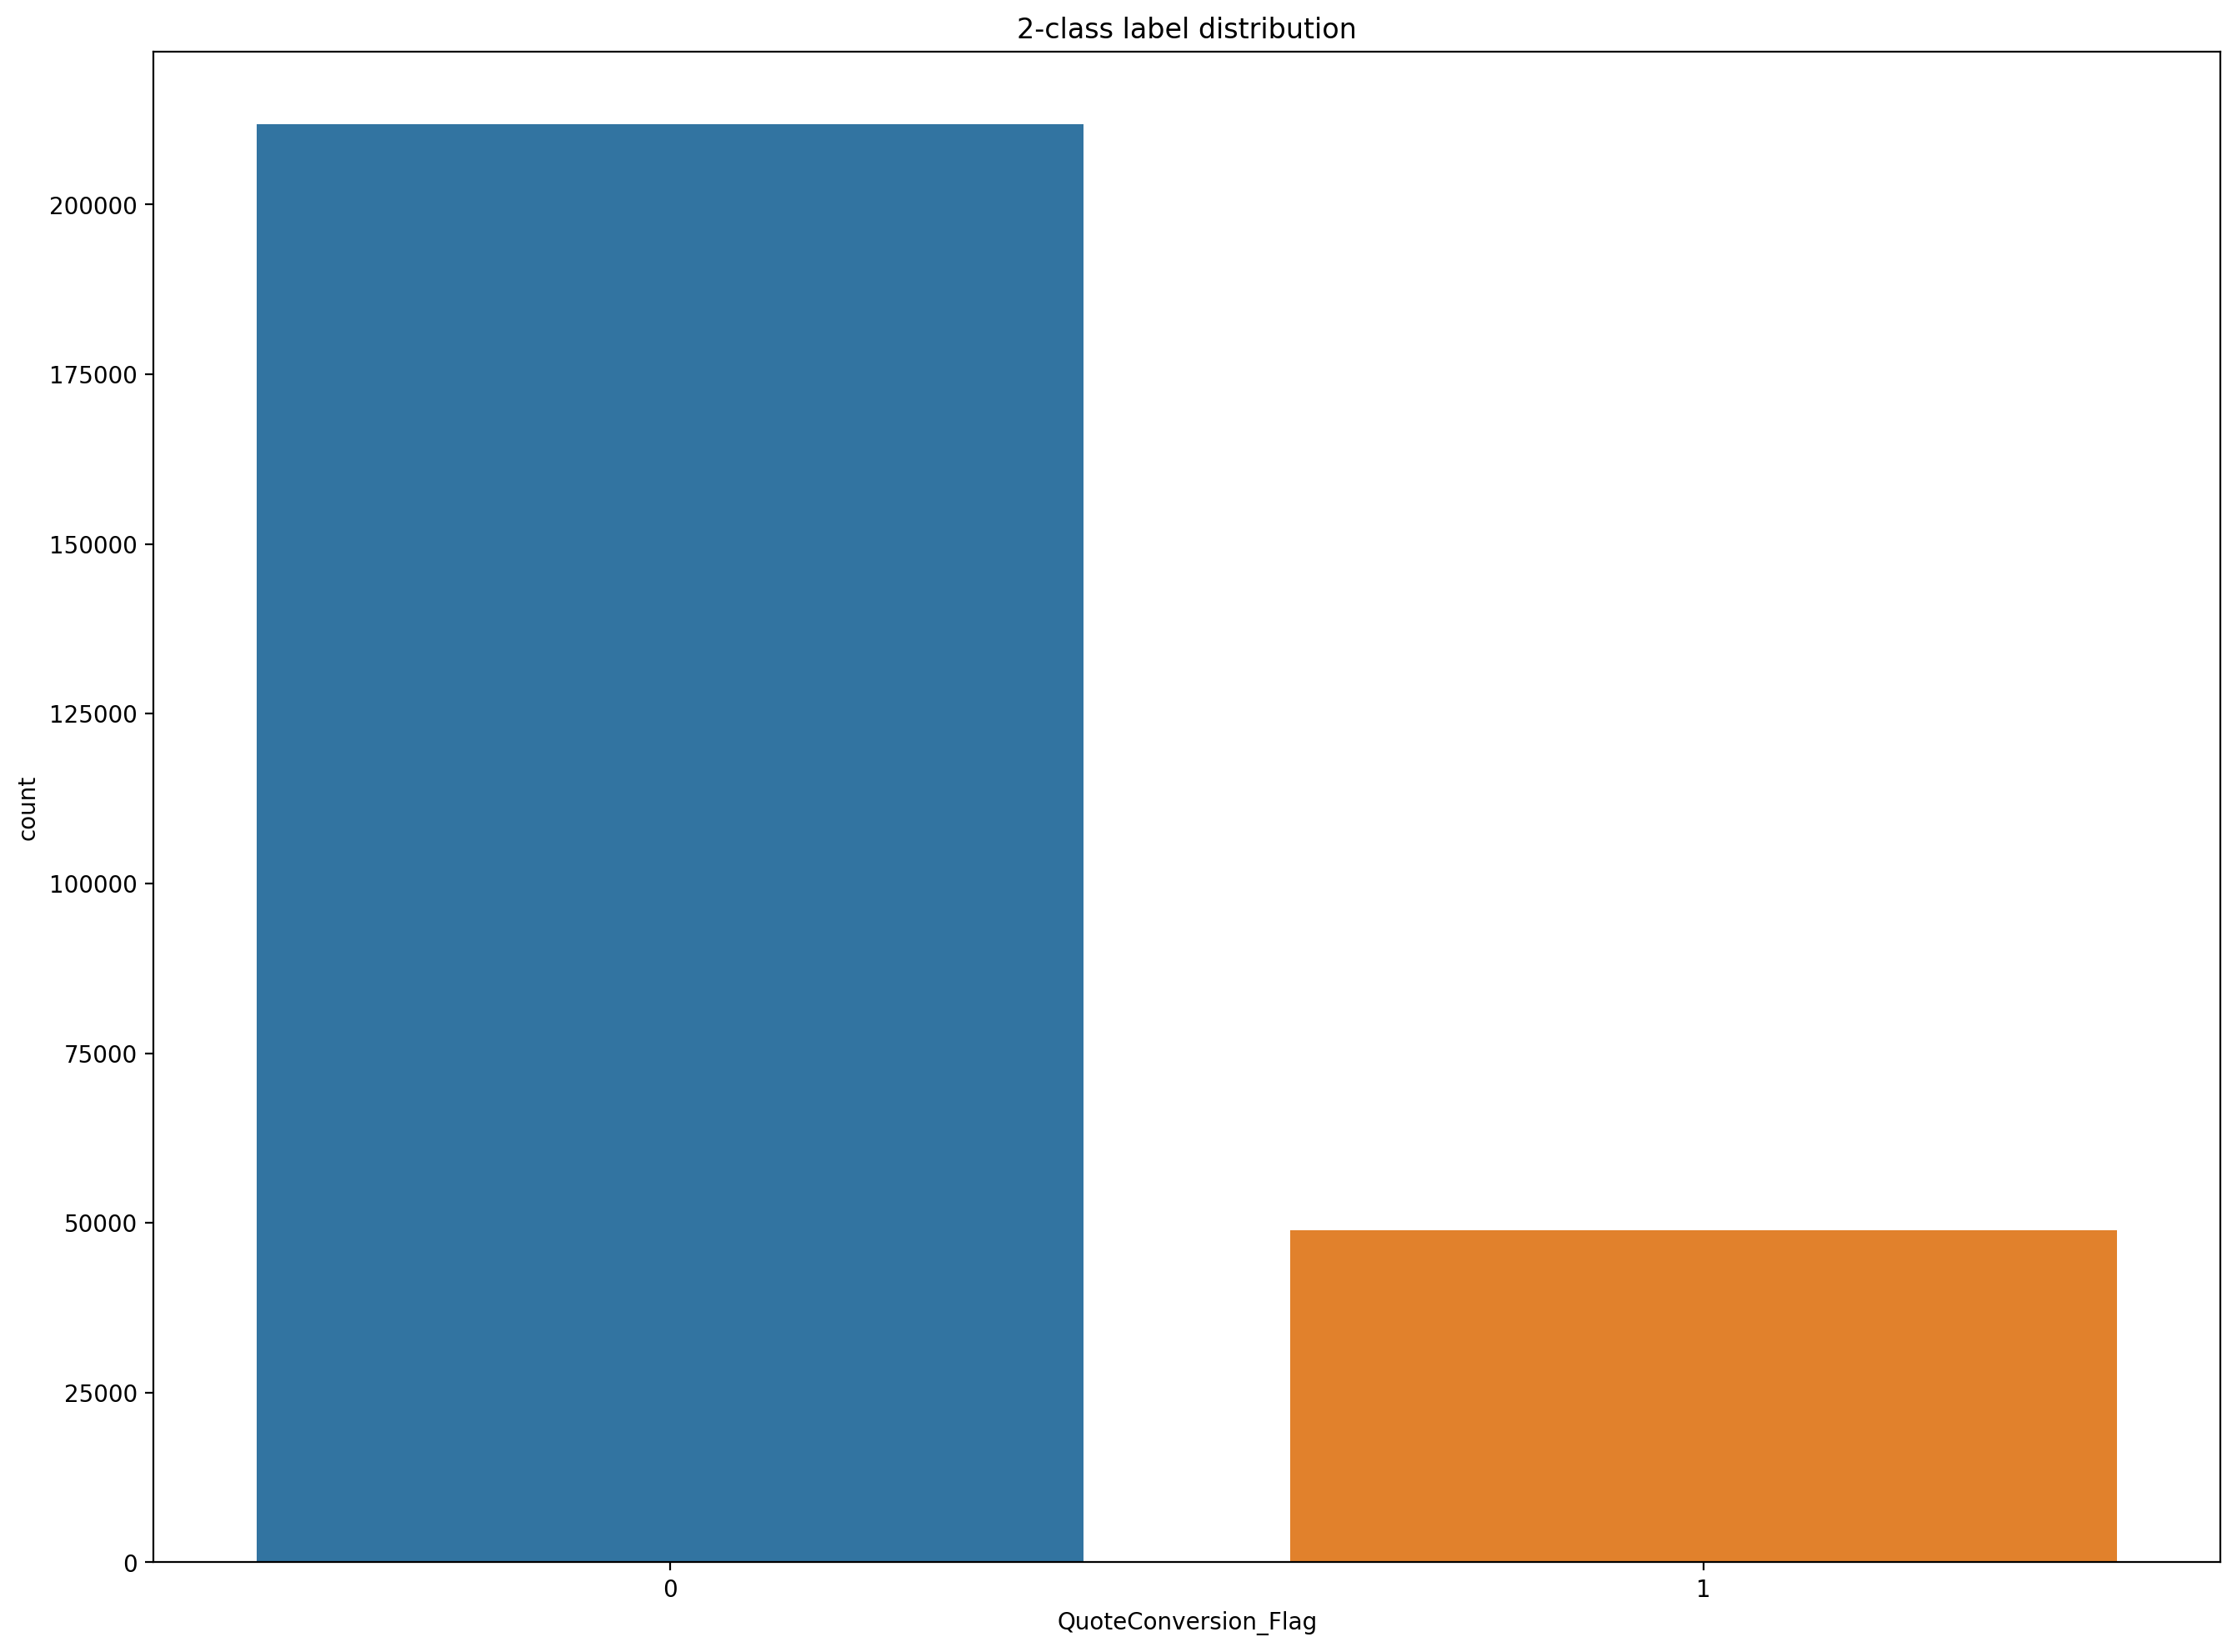

In [17]:
# visualise counts
fig5, ax5 = plt.subplots(figsize=(16,12))
sns.countplot(data = train_df, x='QuoteConversion_Flag').set_title("2-class label distribution")

In [18]:
train_df1.to_csv('train_without_nans.csv', index=False)

#### Check if there are NaN values in the testing set

In [19]:
# check the total number of NaN values
test_df1.isna().sum().sum()

2

In [20]:
# Get the name of the columns were we have NaN values
test_df1.isna().sum()[test_df1.isna().sum() > 0].index

Index(['PropertyField5', 'PropertyField30'], dtype='object')

In [21]:
test_df1

,QuoteNumber,Original_Quote_Date,Field6,Field7,...,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,3,2014-08-12,E,16,...,-1,25,Y,IL
1,5,2013-09-07,F,11,...,-1,21,N,NJ
2,7,2013-03-29,F,15,...,-1,11,N,NJ
3,9,2015-03-21,K,21,...,-1,21,N,TX
4,10,2014-12-10,B,25,...,-1,21,N,CA
...,...,...,...,...,...,...,...,...,...
173831,434570,2014-06-02,F,7,...,-1,9,N,NJ
173832,434573,2015-02-18,B,25,...,-1,20,N,CA
173833,434574,2014-03-29,B,25,...,-1,23,N,CA
173834,434575,2014-03-08,J,26,...,-1,11,N,TX


In [22]:
# An experiment to see what happens if we drop the rows that have NaN values
test_df1.dropna(subset=['PropertyField5', 'PropertyField30'], inplace=True)

In [23]:
test_df1

,QuoteNumber,Original_Quote_Date,Field6,Field7,...,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,3,2014-08-12,E,16,...,-1,25,Y,IL
1,5,2013-09-07,F,11,...,-1,21,N,NJ
2,7,2013-03-29,F,15,...,-1,11,N,NJ
3,9,2015-03-21,K,21,...,-1,21,N,TX
4,10,2014-12-10,B,25,...,-1,21,N,CA
...,...,...,...,...,...,...,...,...,...
173831,434570,2014-06-02,F,7,...,-1,9,N,NJ
173832,434573,2015-02-18,B,25,...,-1,20,N,CA
173833,434574,2014-03-29,B,25,...,-1,23,N,CA
173834,434575,2014-03-08,J,26,...,-1,11,N,TX


In [24]:
# check the total number of NaN values
test_df1.isna().sum().sum()

0

In [25]:
# Get the name of the columns were we have NaN values
test_df1.isna().sum()[test_df1.isna().sum() > 0].index

Index([], dtype='object')

#### Train data profile 

Generate a file to visualise more details about the dataset

In [26]:
# profile = train_df.profile_report(title='Pandas Profiling Report')
# profile.to_file(output_file="homesite_quote_conversion_EDA_1.html")

In [27]:
#train_df.profile_report()

# profile = ProfileReport(train_df, minimal=True)
# profile

#### Test data profile 

In [28]:
# test_df.profile_report()

In [29]:
# profile = ProfileReport(train_df, minimal=True)

# Pre-processing

In [30]:
from fastai.tabular.all import *

In [31]:
# Define idx as 'QuoteNumber'
X_train_fastai = train_df1.set_index('QuoteNumber')
X_test_fastai = test_df1.set_index('QuoteNumber')

In [32]:
X_train_fastai.columns.size, X_test_fastai.columns.size

(289, 288)

In [33]:
# just to verify that the missing column is only the target column
different_columns = X_train_fastai.columns.difference(X_test_fastai.columns)
different_columns

Index(['QuoteConversion_Flag'], dtype='object')

Adding [Tim's](https://redditech.github.io/team-fast-tabulous/jupyter/2021/06/20/Identify-problem-type.html) and [Nissan's](https://redditech.github.io/team-fast-tabulous/kaggle/fastai/2021/06/29/Permutation-Importance-And-Ensemble-Experiment.html) insights

In [34]:
X_train_fastai = add_datepart(X_train_fastai, 'Original_Quote_Date')
X_test = add_datepart(X_test_fastai, 'Original_Quote_Date')

In [35]:
X_train_fastai.columns.size, X_test_fastai.columns.size

(301, 300)

In [36]:
# get the continuous and categorical columns
# Our target column is "QuoteConversion_Flag"
cont_names, cat_names = cont_cat_split(X_train_fastai, dep_var='QuoteConversion_Flag')

In [37]:
X_train_fastai.QuoteConversion_Flag

QuoteNumber
1         0
2         0
4         0
6         0
8         0
         ..
434584    0
434585    0
434586    0
434587    0
434588    0
Name: QuoteConversion_Flag, Length: 260753, dtype: int64

In [38]:
# check if the number of columns is correct
# as we used the quote number as the idx and the target data, 
# for instance: we should get (total_columns - 1) = 300 columns for the train set 
len(cont_names), len(cat_names)

(153, 147)

In [39]:
cat_names

['Field6',
 'Field10',
 'Field12',
 'CoverageField5A',
 'CoverageField5B',
 'CoverageField6A',
 'CoverageField6B',
 'CoverageField8',
 'CoverageField9',
 'SalesField3',
 'SalesField4',
 'SalesField5',
 'SalesField7',
 'SalesField9',
 'SalesField10',
 'SalesField11',
 'SalesField13',
 'SalesField14',
 'SalesField15',
 'PersonalField1',
 'PersonalField2',
 'PersonalField5',
 'PersonalField6',
 'PersonalField8',
 'PersonalField9',
 'PersonalField11',
 'PersonalField12',
 'PersonalField13',
 'PersonalField16',
 'PersonalField17',
 'PersonalField18',
 'PersonalField19',
 'PersonalField22',
 'PersonalField23',
 'PersonalField24',
 'PersonalField25',
 'PersonalField26',
 'PersonalField27',
 'PersonalField28',
 'PersonalField29',
 'PersonalField30',
 'PersonalField31',
 'PersonalField32',
 'PersonalField33',
 'PersonalField34',
 'PersonalField35',
 'PersonalField36',
 'PersonalField37',
 'PersonalField38',
 'PersonalField39',
 'PersonalField40',
 'PersonalField41',
 'PersonalField42',
 'Person

In [40]:
# check if the target column is not in the categorical or continous columns
"QuoteConversion_Flag" in cont_names, "QuoteConversion_Flag" in cat_names

(False, False)

Following [Nissan's](https://redditech.github.io/team-fast-tabulous/kaggle/fastai/2021/06/29/Permutation-Importance-And-Ensemble-Experiment.html) approach:

In [41]:
# create the data loaders for tabular fastai

target_column = 'QuoteConversion_Flag'

# some parameters for the data loader function
random_seed = 42
set_seed(random_seed)
batch_size = 1024
layers = [250, 500, 1000]
dropout = [0.2, 0.2, 0.2]
emb_dropout=0.02
test_size = 0.25

procs = [Categorify, FillMissing, Normalize]
splits = TrainTestSplitter(test_size=test_size, stratify=X_train_fastai[target_column])(X_train_fastai)

to_train = TabularPandas(df=X_train_fastai, 
                   procs=procs,
                   cat_names=cat_names, 
                   cont_names=cont_names,
                   y_names=target_column,
                   splits=splits,
                   y_block=CategoryBlock())



dls = to_train.dataloaders(bs=batch_size, val_bs=batch_size, layers=layers, embed_ps=emb_dropout, ps=dropout)
dls.valid.show_batch()

,Field6,Field10,Field12,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,SalesField3,SalesField4,SalesField5,SalesField7,SalesField9,SalesField10,SalesField11,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField5,PersonalField6,PersonalField8,PersonalField9,PersonalField11,PersonalField12,PersonalField13,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,PersonalField31,PersonalField32,PersonalField33,PersonalField34,PersonalField35,PersonalField36,PersonalField37,PersonalField38,PersonalField39,PersonalField40,PersonalField41,PersonalField42,PersonalField43,PersonalField44,PersonalField45,PersonalField46,PersonalField47,PersonalField48,PersonalField49,PersonalField50,PersonalField51,PersonalField52,PersonalField53,PersonalField54,PersonalField55,PersonalField56,PersonalField57,PersonalField58,PersonalField59,PersonalField60,PersonalField61,PersonalField62,PersonalField63,PersonalField64,PersonalField65,PersonalField66,PersonalField67,PersonalField68,PersonalField69,PersonalField70,PersonalField71,PersonalField72,PersonalField73,PersonalField74,PersonalField75,PersonalField76,PersonalField77,PersonalField78,PersonalField79,PersonalField80,PersonalField81,PersonalField82,PersonalField83,PropertyField2A,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField17,PropertyField18,PropertyField19,PropertyField20,PropertyField22,PropertyField23,PropertyField27,PropertyField28,PropertyField30,PropertyField31,PropertyField33,PropertyField35,PropertyField37,GeographicField5A,GeographicField5B,GeographicField10A,GeographicField10B,GeographicField14A,GeographicField14B,GeographicField18A,GeographicField21A,GeographicField22A,GeographicField22B,GeographicField23A,GeographicField56A,GeographicField60A,GeographicField61A,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64,Original_Quote_Year,Original_Quote_Month,Original_Quote_Dayofweek,Original_Quote_Is_month_end,Original_Quote_Is_month_start,Original_Quote_Is_quarter_end,Original_Quote_Is_quarter_start,Original_Quote_Is_year_end,Original_Quote_Is_year_start,Field7,Field8,Field9,Field11,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField6,SalesField8,SalesField12,PersonalField4A,PersonalField4B,PersonalField10A,PersonalField10B,PersonalField14,PersonalField15,PropertyField1A,PropertyField1B,PropertyField2B,PropertyField16A,PropertyField16B,PropertyField21A,PropertyField21B,PropertyField24A,PropertyField24B,PropertyField25,PropertyField26A,PropertyField26B,PropertyField39A,PropertyField39B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A,GeographicField13B,GeographicField15A,GeographicField15B,GeographicField16A,GeographicField16B,GeographicField17A,GeographicField17B,GeographicField18B,GeographicField19A,GeographicField19B,GeographicField20A,GeographicField20B,GeographicField21B,GeographicField23B,GeographicField24A,GeographicField24B,GeographicField25A,GeographicField25B,GeographicField26A,GeographicField26B,GeographicField27A,GeographicField27B,GeographicField28A,GeographicField28B,GeographicField29A,GeographicField29B,GeographicField30A,GeographicField30B,GeographicField31A,GeographicField31B,Geogr

In [42]:
# As the metrics for the Kaggle challenge are defined for ROC AUC value, we will define it in the learner  
learn = tabular_learner(dls,
                        metrics=[accuracy,
                                 RocAucBinary(),
                                 Recall(),
                                 Precision()],
                        #callback_fns=ShowGraph
                       )

In [43]:
learn.summary()

TabularModel (Input shape: 1024 x torch.Size([1024, 153]))
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 5            
Embedding                                 45         True      
Embedding                                 45         True      
____________________________________________________________________________
                     1024 x 3            
Embedding                                 9          True      
Embedding                                 12         True      
____________________________________________________________________________
                     1024 x 4            
Embedding                                 20         True      
____________________________________________________________________________
                     1024 x 3            
Embedding                                 12         True      
____________________________________________________________________________
                 

SuggestedLRs(valley=tensor(0.0008), slide=tensor(0.0331), minimum=0.05248074531555176, steep=0.04786301031708717)

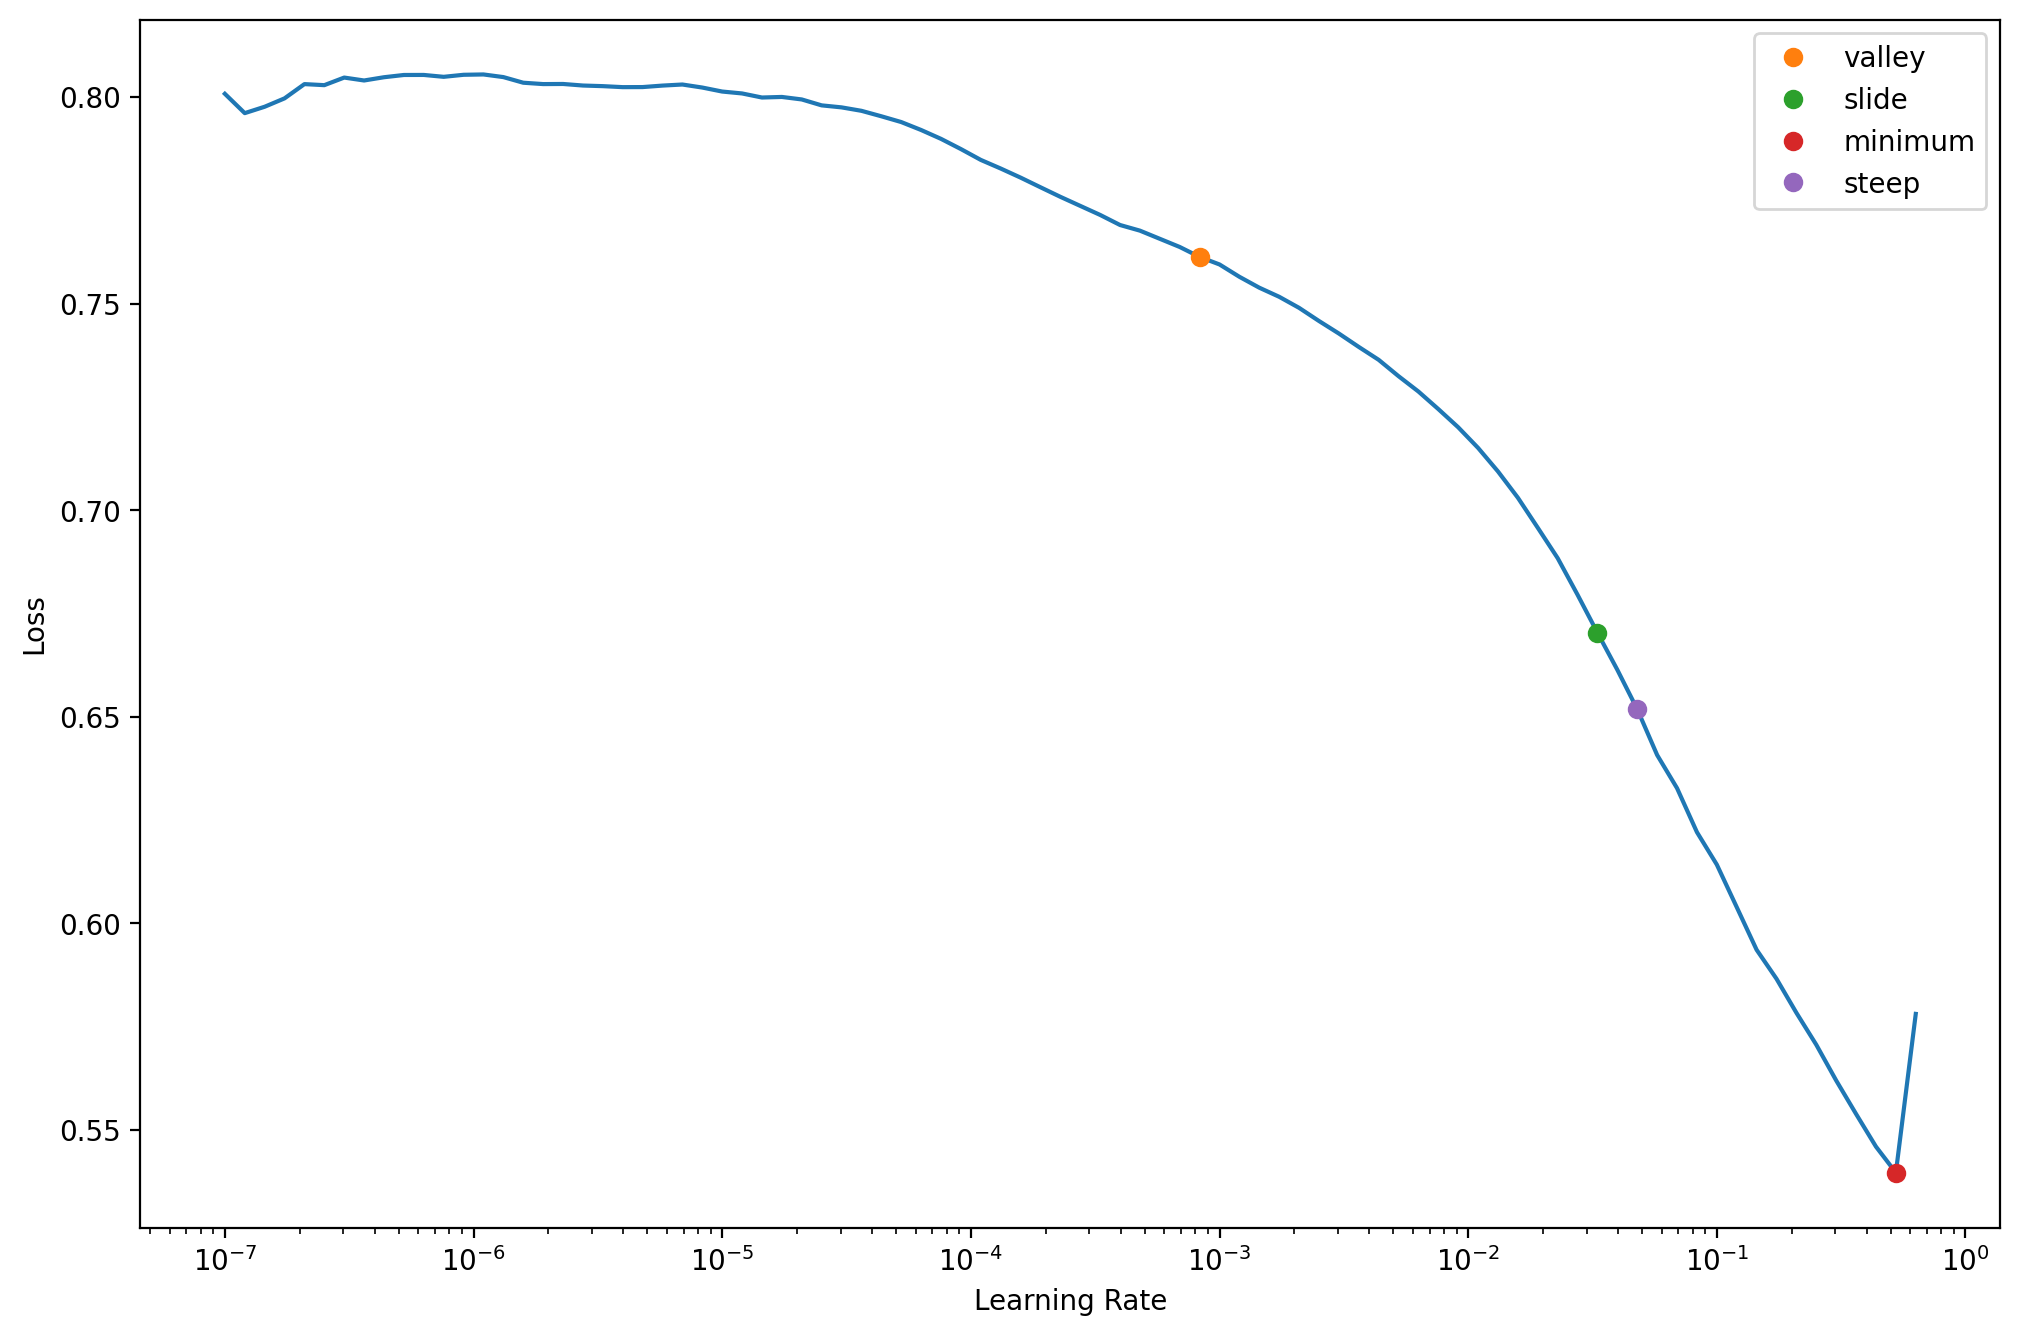

In [44]:
# With this line we will find and visualise different learning rates 
# and it might help to choose a good value 
learn.lr_find(suggest_funcs=(valley, slide, minimum, steep))

epoch,train_loss,valid_loss,accuracy,roc_auc_score,recall_score,precision_score,time
0,0.222679,0.215133,0.905521,0.950922,0.768161,0.738498,01:22
1,0.190484,0.190759,0.918529,0.954821,0.685209,0.851306,01:21
2,0.184767,0.185184,0.920278,0.957901,0.726931,0.826989,01:21
3,0.176265,0.182358,0.922257,0.959412,0.711796,0.849209,01:21
4,0.168345,0.180767,0.922671,0.960028,0.702798,0.859186,01:21


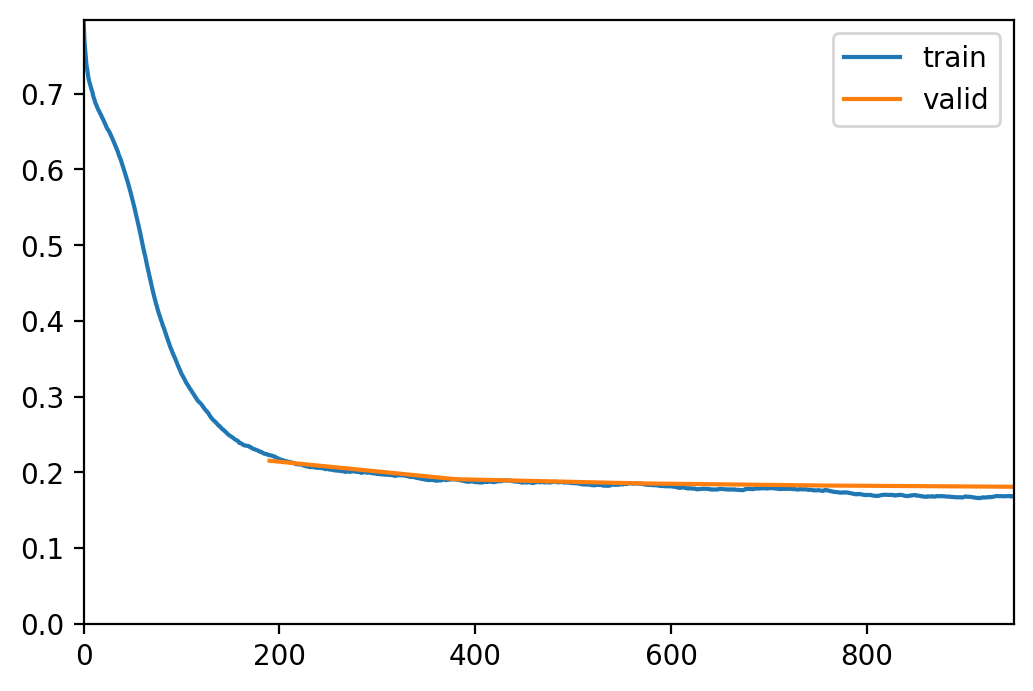

In [45]:
# define some parameters for the model
epochs = 5
lr = 0.0229
weight_decay = 0.002

learn.fit_one_cycle(epochs,
                    lr, 
                    wd=weight_decay,
                    cbs=[ShowGraphCallback()]
                   )

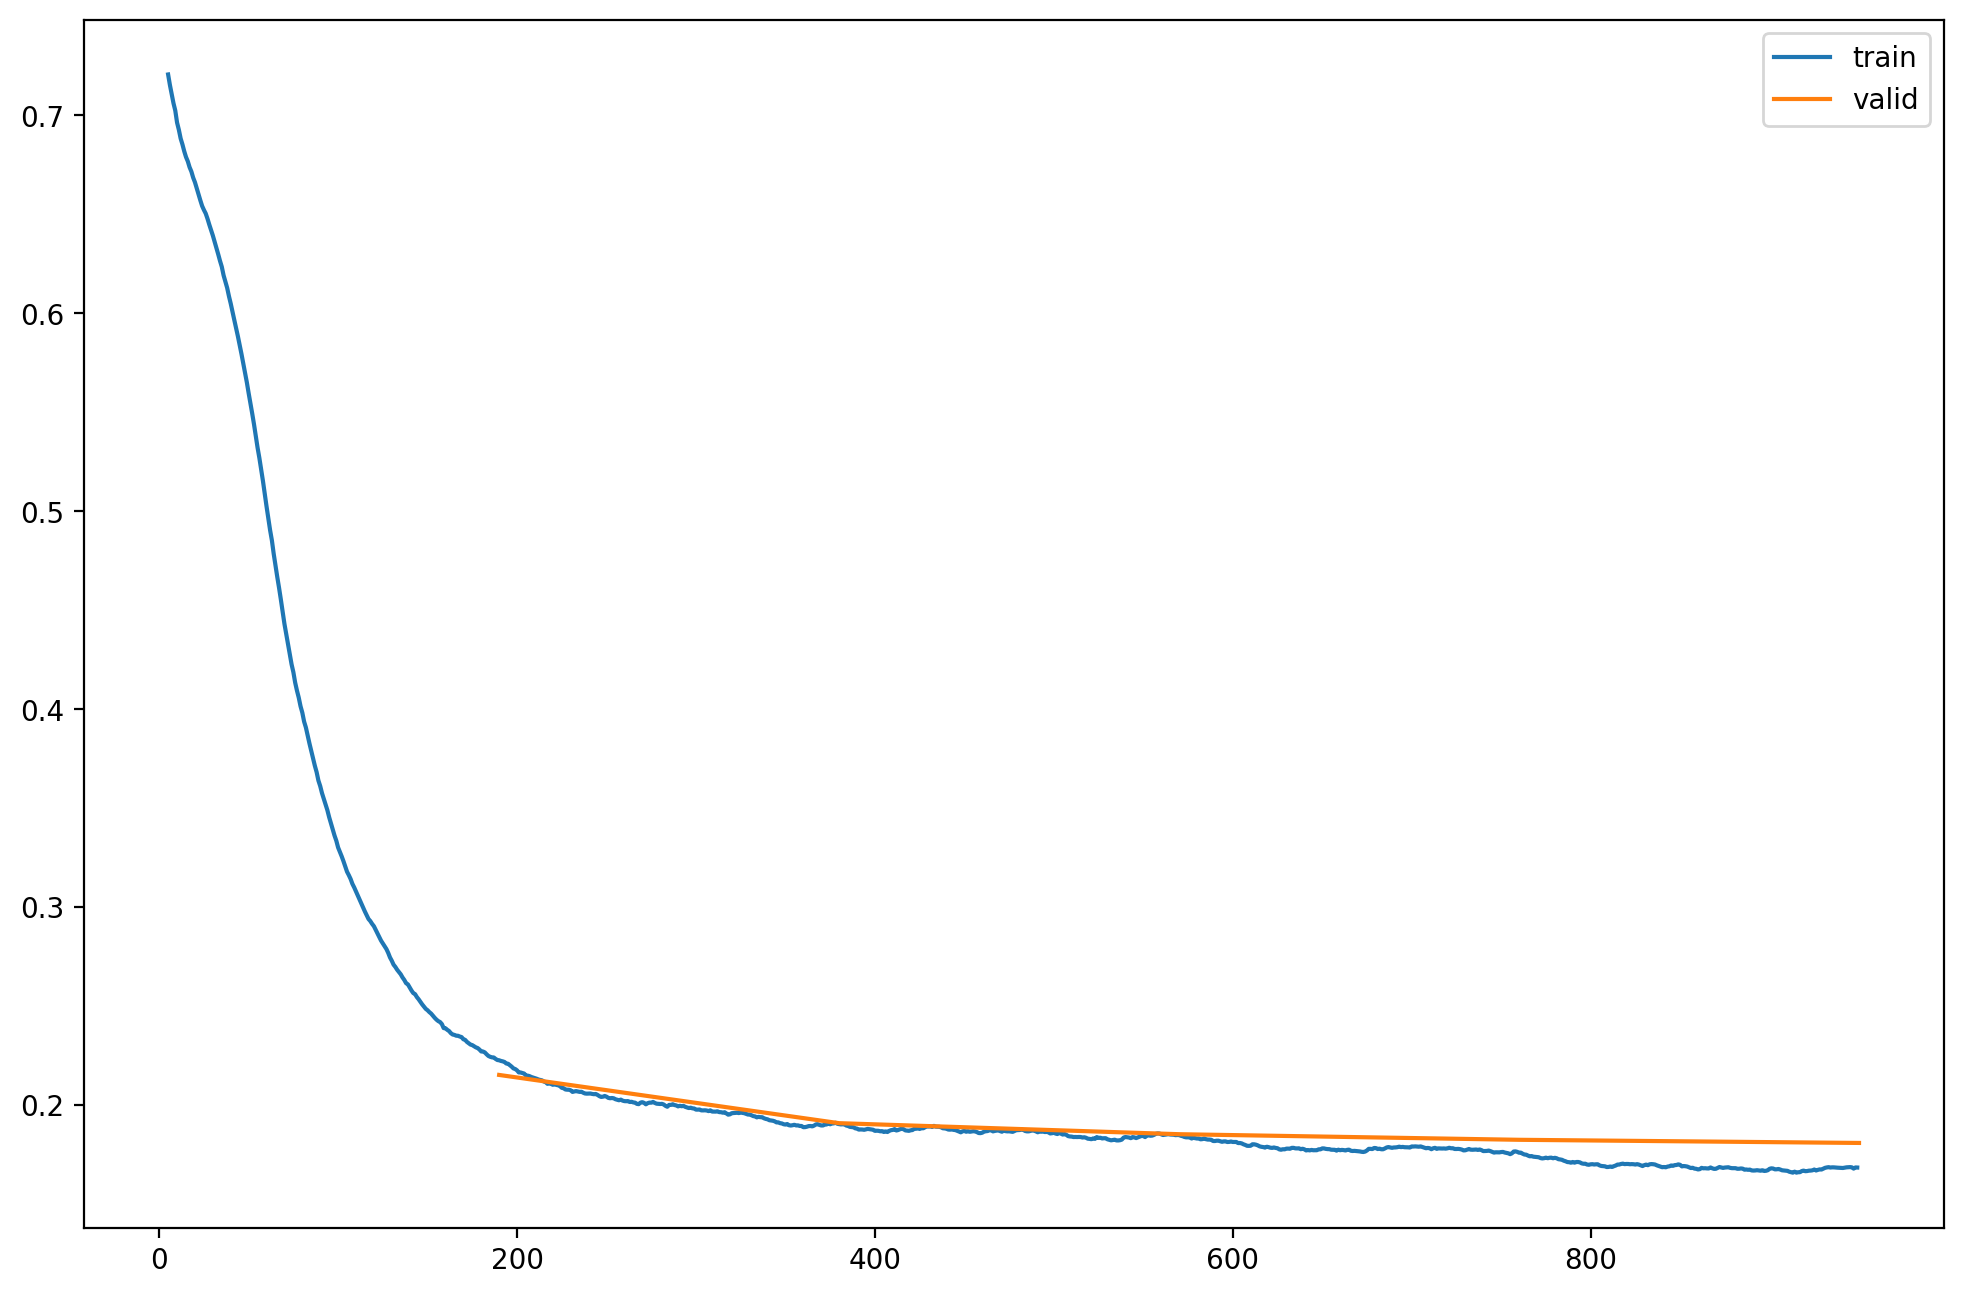

In [46]:
learn.recorder.plot_loss()

In [47]:
preds, y, losses = learn.get_preds(with_loss=True)

In [48]:
to_np(y)

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int8)

Just to check/validate the results from FastAI. Taken from Nissan's notebook [notebook](https://redditech.github.io/team-fast-tabulous/kaggle/fastai/2021/07/04/_First_Pass_Using_Fastai_For_Homesite_Competition.html) and [here](https://www.kaggle.com/quanghm/fastai-1-0-tabular-learner-with-ensemble?scriptVersionId=12269139)

In [49]:
from sklearn.metrics import roc_auc_score
fastai_score = roc_auc_score(to_np(y), to_np(preds[:,1]))
fastai_score

0.9600280084385965

In [50]:
interpretation_results = ClassificationInterpretation.from_learner(learn)

In [51]:
interpretation_results.confusion_matrix()

array([[51557,  1408],
       [ 3633,  8591]], dtype=int64)

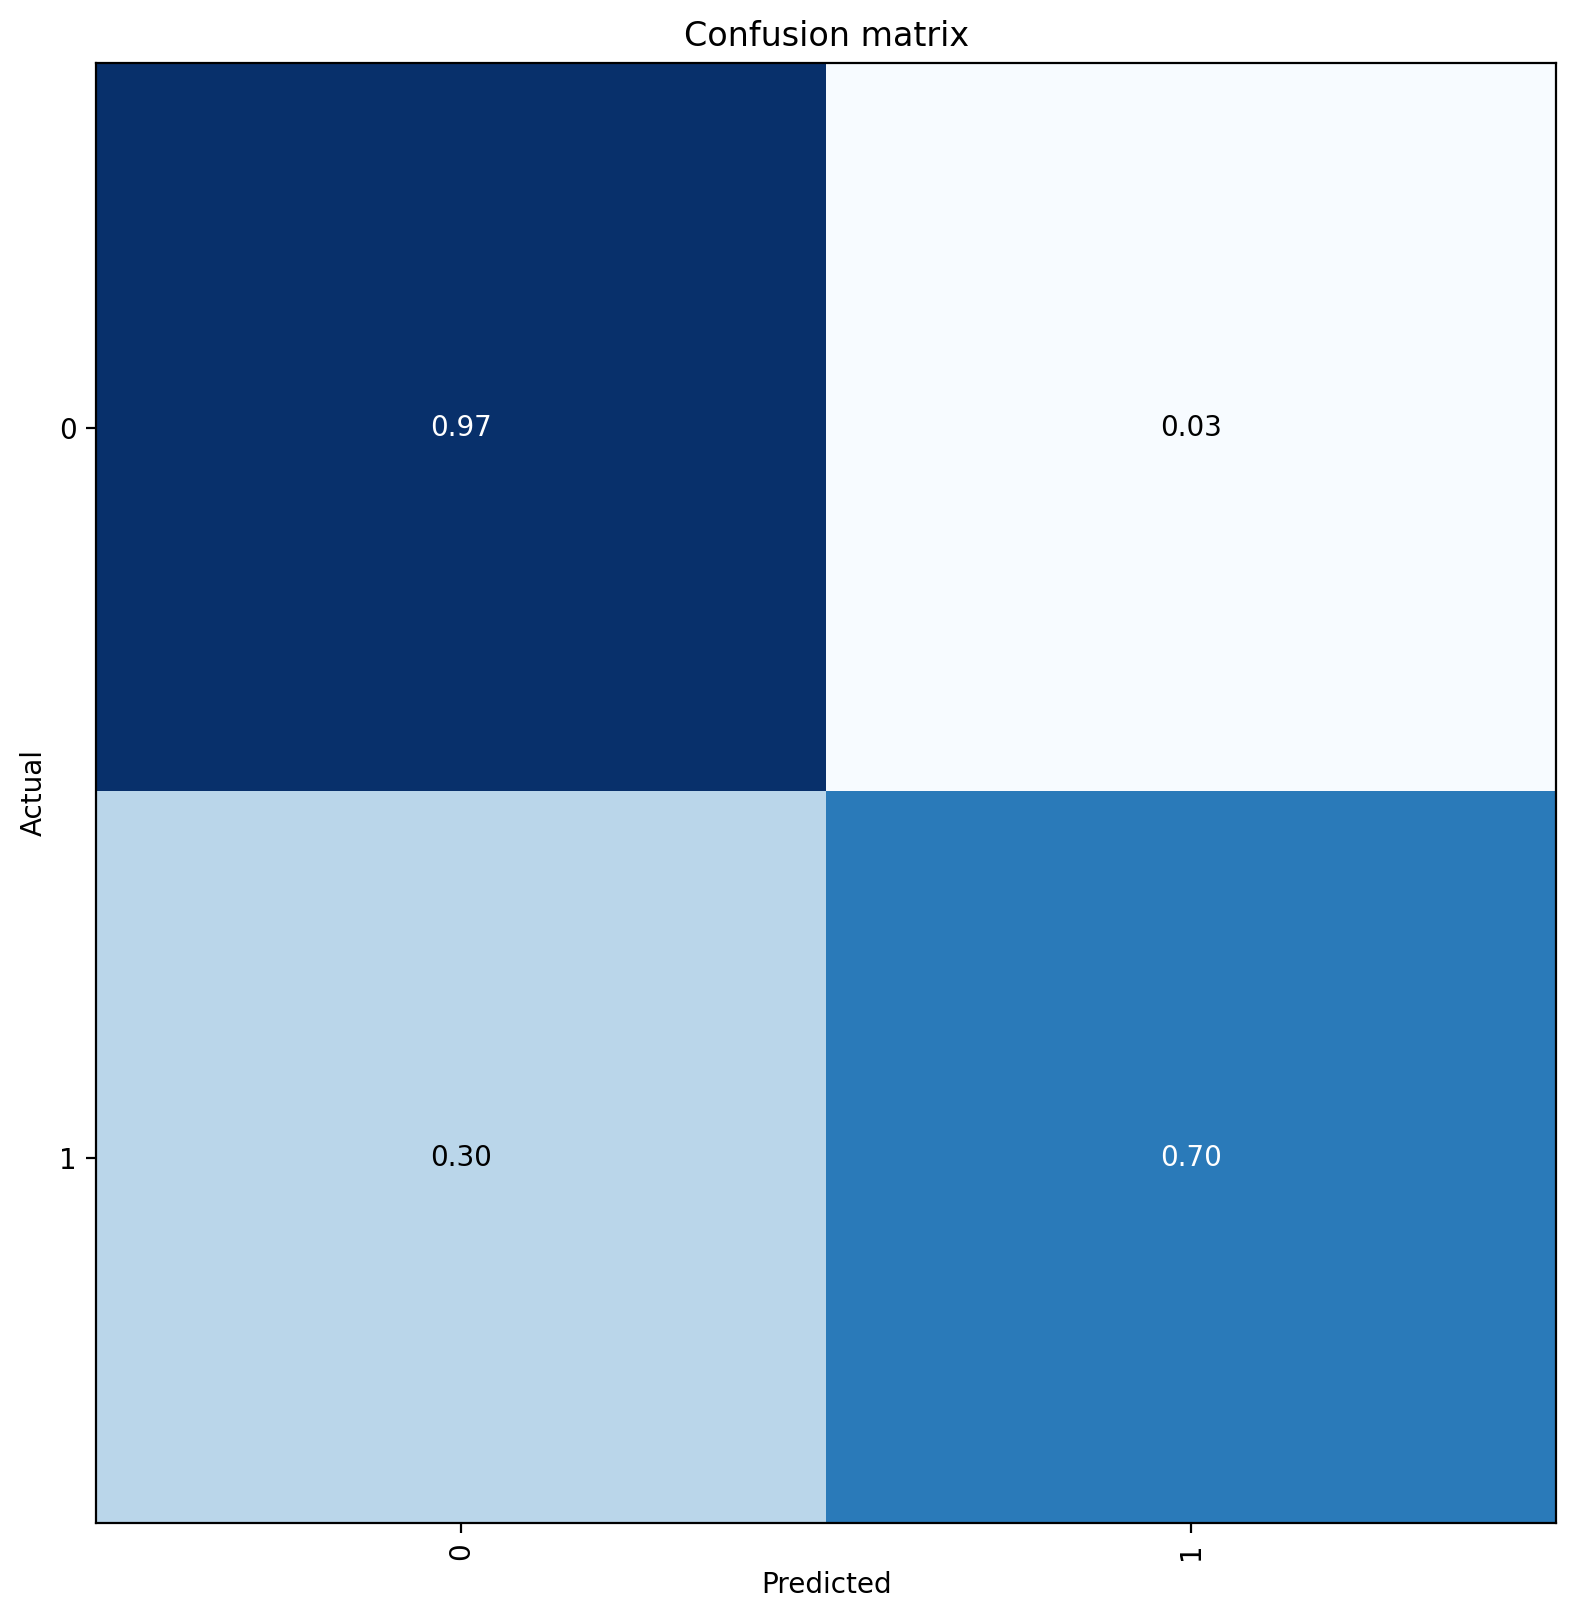

In [52]:
interpretation_results.plot_confusion_matrix(normalize=True)

## Evaluating the test set

In [53]:
to_test = TabularPandas(df=X_test_fastai, procs=procs, cat_names=cat_names, cont_names=cont_names)
test_dls = to_test.dataloaders()
test_dls.show_batch()

,Field6,Field10,Field12,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,SalesField3,SalesField4,SalesField5,SalesField7,SalesField9,SalesField10,SalesField11,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField5,PersonalField6,PersonalField8,PersonalField9,PersonalField11,PersonalField12,PersonalField13,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,PersonalField31,PersonalField32,PersonalField33,PersonalField34,PersonalField35,PersonalField36,PersonalField37,PersonalField38,PersonalField39,PersonalField40,PersonalField41,PersonalField42,PersonalField43,PersonalField44,PersonalField45,PersonalField46,PersonalField47,PersonalField48,PersonalField49,PersonalField50,PersonalField51,PersonalField52,PersonalField53,PersonalField54,PersonalField55,PersonalField56,PersonalField57,PersonalField58,PersonalField59,PersonalField60,PersonalField61,PersonalField62,PersonalField63,PersonalField64,PersonalField65,PersonalField66,PersonalField67,PersonalField68,PersonalField69,PersonalField70,PersonalField71,PersonalField72,PersonalField73,PersonalField74,PersonalField75,PersonalField76,PersonalField77,PersonalField78,PersonalField79,PersonalField80,PersonalField81,PersonalField82,PersonalField83,PropertyField2A,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField17,PropertyField18,PropertyField19,PropertyField20,PropertyField22,PropertyField23,PropertyField27,PropertyField28,PropertyField30,PropertyField31,PropertyField33,PropertyField35,PropertyField37,GeographicField5A,GeographicField5B,GeographicField10A,GeographicField10B,GeographicField14A,GeographicField14B,GeographicField18A,GeographicField21A,GeographicField22A,GeographicField22B,GeographicField23A,GeographicField56A,GeographicField60A,GeographicField61A,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64,Original_Quote_Year,Original_Quote_Month,Original_Quote_Dayofweek,Original_Quote_Is_month_end,Original_Quote_Is_month_start,Original_Quote_Is_quarter_end,Original_Quote_Is_quarter_start,Original_Quote_Is_year_end,Original_Quote_Is_year_start,Field7,Field8,Field9,Field11,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField6,SalesField8,SalesField12,PersonalField4A,PersonalField4B,PersonalField10A,PersonalField10B,PersonalField14,PersonalField15,PropertyField1A,PropertyField1B,PropertyField2B,PropertyField16A,PropertyField16B,PropertyField21A,PropertyField21B,PropertyField24A,PropertyField24B,PropertyField25,PropertyField26A,PropertyField26B,PropertyField39A,PropertyField39B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A,GeographicField13B,GeographicField15A,GeographicField15B,GeographicField16A,GeographicField16B,GeographicField17A,GeographicField17B,GeographicField18B,GeographicField19A,GeographicField19B,GeographicField20A,GeographicField20B,GeographicField21B,GeographicField23B,GeographicField24A,GeographicField24B,GeographicField25A,GeographicField25B,GeographicField26A,GeographicField26B,GeographicField27A,GeographicField27B,GeographicField28A,GeographicField28B,GeographicField29A,GeographicField29B,GeographicField30A,GeographicField30B,GeographicField31A,GeographicField31B,Geogr

There are two options to perform inference

- Row wise 
- Batch wise

Taken from Nissan's [notebook](https://redditech.github.io/team-fast-tabulous/kaggle/fastai/2021/07/04/_First_Pass_Using_Fastai_For_Homesite_Competition.html) and [here](https://walkwithfastai.com/tab.clas.binary)

In [54]:
# Row wise
row, cls, probs = learn.predict(X_test_fastai.iloc[0])
row.show()

,Field6,Field10,Field12,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,SalesField3,SalesField4,SalesField5,SalesField7,SalesField9,SalesField10,SalesField11,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField5,PersonalField6,PersonalField8,PersonalField9,PersonalField11,PersonalField12,PersonalField13,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,PersonalField31,PersonalField32,PersonalField33,PersonalField34,PersonalField35,PersonalField36,PersonalField37,PersonalField38,PersonalField39,PersonalField40,PersonalField41,PersonalField42,PersonalField43,PersonalField44,PersonalField45,PersonalField46,PersonalField47,PersonalField48,PersonalField49,PersonalField50,PersonalField51,PersonalField52,PersonalField53,PersonalField54,PersonalField55,PersonalField56,PersonalField57,PersonalField58,PersonalField59,PersonalField60,PersonalField61,PersonalField62,PersonalField63,PersonalField64,PersonalField65,PersonalField66,PersonalField67,PersonalField68,PersonalField69,PersonalField70,PersonalField71,PersonalField72,PersonalField73,PersonalField74,PersonalField75,PersonalField76,PersonalField77,PersonalField78,PersonalField79,PersonalField80,PersonalField81,PersonalField82,PersonalField83,PropertyField2A,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField17,PropertyField18,PropertyField19,PropertyField20,PropertyField22,PropertyField23,PropertyField27,PropertyField28,PropertyField30,PropertyField31,PropertyField33,PropertyField35,PropertyField37,GeographicField5A,GeographicField5B,GeographicField10A,GeographicField10B,GeographicField14A,GeographicField14B,GeographicField18A,GeographicField21A,GeographicField22A,GeographicField22B,GeographicField23A,GeographicField56A,GeographicField60A,GeographicField61A,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64,Original_Quote_Year,Original_Quote_Month,Original_Quote_Dayofweek,Original_Quote_Is_month_end,Original_Quote_Is_month_start,Original_Quote_Is_quarter_end,Original_Quote_Is_quarter_start,Original_Quote_Is_year_end,Original_Quote_Is_year_start,Field7,Field8,Field9,Field11,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField6,SalesField8,SalesField12,PersonalField4A,PersonalField4B,PersonalField10A,PersonalField10B,PersonalField14,PersonalField15,PropertyField1A,PropertyField1B,PropertyField2B,PropertyField16A,PropertyField16B,PropertyField21A,PropertyField21B,PropertyField24A,PropertyField24B,PropertyField25,PropertyField26A,PropertyField26B,PropertyField39A,PropertyField39B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A,GeographicField13B,GeographicField15A,GeographicField15B,GeographicField16A,GeographicField16B,GeographicField17A,GeographicField17B,GeographicField18B,GeographicField19A,GeographicField19B,GeographicField20A,GeographicField20B,GeographicField21B,GeographicField23B,GeographicField24A,GeographicField24B,GeographicField25A,GeographicField25B,GeographicField26A,GeographicField26B,GeographicField27A,GeographicField27B,GeographicField28A,GeographicField28B,GeographicField29A,GeographicField29B,GeographicField30A,GeographicField30B,GeographicField31A,GeographicField31B,Geogr

In [55]:
# Batch wise
dl_test = learn.dls.test_dl(X_test_fastai.iloc[:])
dl_test.show_batch()

,Field6,Field10,Field12,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,SalesField3,SalesField4,SalesField5,SalesField7,SalesField9,SalesField10,SalesField11,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField5,PersonalField6,PersonalField8,PersonalField9,PersonalField11,PersonalField12,PersonalField13,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,PersonalField31,PersonalField32,PersonalField33,PersonalField34,PersonalField35,PersonalField36,PersonalField37,PersonalField38,PersonalField39,PersonalField40,PersonalField41,PersonalField42,PersonalField43,PersonalField44,PersonalField45,PersonalField46,PersonalField47,PersonalField48,PersonalField49,PersonalField50,PersonalField51,PersonalField52,PersonalField53,PersonalField54,PersonalField55,PersonalField56,PersonalField57,PersonalField58,PersonalField59,PersonalField60,PersonalField61,PersonalField62,PersonalField63,PersonalField64,PersonalField65,PersonalField66,PersonalField67,PersonalField68,PersonalField69,PersonalField70,PersonalField71,PersonalField72,PersonalField73,PersonalField74,PersonalField75,PersonalField76,PersonalField77,PersonalField78,PersonalField79,PersonalField80,PersonalField81,PersonalField82,PersonalField83,PropertyField2A,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField17,PropertyField18,PropertyField19,PropertyField20,PropertyField22,PropertyField23,PropertyField27,PropertyField28,PropertyField30,PropertyField31,PropertyField33,PropertyField35,PropertyField37,GeographicField5A,GeographicField5B,GeographicField10A,GeographicField10B,GeographicField14A,GeographicField14B,GeographicField18A,GeographicField21A,GeographicField22A,GeographicField22B,GeographicField23A,GeographicField56A,GeographicField60A,GeographicField61A,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64,Original_Quote_Year,Original_Quote_Month,Original_Quote_Dayofweek,Original_Quote_Is_month_end,Original_Quote_Is_month_start,Original_Quote_Is_quarter_end,Original_Quote_Is_quarter_start,Original_Quote_Is_year_end,Original_Quote_Is_year_start,Field7,Field8,Field9,Field11,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField6,SalesField8,SalesField12,PersonalField4A,PersonalField4B,PersonalField10A,PersonalField10B,PersonalField14,PersonalField15,PropertyField1A,PropertyField1B,PropertyField2B,PropertyField16A,PropertyField16B,PropertyField21A,PropertyField21B,PropertyField24A,PropertyField24B,PropertyField25,PropertyField26A,PropertyField26B,PropertyField39A,PropertyField39B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A,GeographicField13B,GeographicField15A,GeographicField15B,GeographicField16A,GeographicField16B,GeographicField17A,GeographicField17B,GeographicField18B,GeographicField19A,GeographicField19B,GeographicField20A,GeographicField20B,GeographicField21B,GeographicField23B,GeographicField24A,GeographicField24B,GeographicField25A,GeographicField25B,GeographicField26A,GeographicField26B,GeographicField27A,GeographicField27B,GeographicField28A,GeographicField28B,GeographicField29A,GeographicField29B,GeographicField30A,GeographicField30B,GeographicField31A,GeographicField31B,Geogr

# XGBoost

Following [Nissan's](https://redditech.github.io/team-fast-tabulous/kaggle/fastai/2021/06/29/Permutation-Importance-And-Ensemble-Experiment.html) approach:

In [56]:
import xgboost as xgb
from xgboost import plot_importance

In [57]:
n_estimators = 100
max_depth = 8
learning_rate = 0.1
subsample = 0.5

In [58]:
X_train_xgb, y_train_xgb = to_train.train.xs, to_train.train.ys.values.ravel()
X_valid_xgb, y_valid_xgb = to_train.valid.xs, to_train.valid.ys.values.ravel()

In [59]:
model = xgb.XGBClassifier(n_estimators = n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample)

In [60]:
xgb_model = model.fit(X_train_xgb, y_train_xgb)

C:\Users\ML\.conda\envs\fastai\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [61]:
xgb_preds = xgb_model.predict_proba(X_valid_xgb)

In [62]:
xgb_preds

array([[0.9985389 , 0.00146107],
       [0.9971962 , 0.00280382],
       [0.8347542 , 0.16524576],
       ...,
       [0.96014047, 0.03985953],
       [0.98155385, 0.01844615],
       [0.99842244, 0.00157756]], dtype=float32)

In [63]:
xgb_preds[:,1]

array([0.00146107, 0.00280382, 0.16524576, ..., 0.03985953, 0.01844615,
       0.00157756], dtype=float32)

In [64]:
accuracy(tensor(xgb_preds), tensor(y_valid_xgb))

TensorBase(0.9243)

In [65]:
y_valid_xgb

array([0, 0, 1, ..., 0, 0, 0], dtype=int8)

In [66]:
xgboost_score = roc_auc_score(y_valid_xgb, xgb_preds[:,1])
xgboost_score

0.9628106816192457

## Random Forest

Following [Tracy's](https://redditech.github.io/team-fast-tabulous/jupyter/2021/06/20/Basic-Random-Forest-Score-0.953.html) approach:

In [67]:
X_train_rf = X_train_xgb
y_train_rf = y_train_xgb
X_valid_rf = X_valid_xgb
y_valid_rf = y_valid_xgb

In [68]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_rf,y_train_rf)

RandomForestClassifier()

In [69]:
rf_preds = rfc.predict_proba(X_valid_rf)

In [70]:
rf_score = roc_auc_score(y_valid_rf, rf_preds[:,1])
rf_score

0.9531100126071104

# Results of the three models

In [71]:
fastai_score, xgboost_score, rf_score

(0.9600280084385965, 0.9628106816192457, 0.9531100126071104)

In [72]:
send_tg_message('first results are ready')

# Checking the models's performance when reducing the number of columns according to their importance

### Permutation importance for FastAI tabular learner

Permutation importance is a technique in which we shuffle each column in a dataframe and analyze how changing a particular column affected our y values. The more that it was affected, the more "important" we can (generally) call a variable in our neural network.

Source: https://walkwithfastai.com/Regression_and_Permutation_Importance

Following [Nissan's](https://redditech.github.io/team-fast-tabulous/kaggle/fastai/2021/06/29/Permutation-Importance-And-Ensemble-Experiment.html) approach:

In [73]:
class PermutationImportance():
  "Calculate and plot the permutation importance"
  def __init__(self, learn:Learner, df=None, bs=None):
    "Initialize with a test dataframe, a learner, and a metric"
    self.learn = learn
    self.df = df if df is not None else None
    bs = bs if bs is not None else learn.dls.bs
    self.dl = learn.dls.test_dl(self.df, bs=bs) if self.df is not None else learn.dls[1]
    self.x_names = learn.dls.x_names.filter(lambda x: '_na' not in x)
    self.na = learn.dls.x_names.filter(lambda x: '_na' in x)
    self.y = dls.y_names
    self.results = self.calc_feat_importance()
    self.plot_importance(self.ord_dic_to_df(self.results))

  def measure_col(self, name:str):
    "Measures change after column shuffle"
    col = [name]
    if f'{name}_na' in self.na: col.append(name)
    orig = self.dl.items[col].values
    perm = np.random.permutation(len(orig))
    self.dl.items[col] = self.dl.items[col].values[perm]
    metric = learn.validate(dl=self.dl)[1]
    self.dl.items[col] = orig
    return metric

  def calc_feat_importance(self):
    "Calculates permutation importance by shuffling a column on a percentage scale"
    print('Getting base error')
    base_error = self.learn.validate(dl=self.dl)[1]
    self.importance = {}
    pbar = progress_bar(self.x_names)
    print('Calculating Permutation Importance')
    for col in pbar:
      self.importance[col] = self.measure_col(col)
    for key, value in self.importance.items():
      self.importance[key] = (base_error-value)/base_error #this can be adjusted
    return OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))

  def ord_dic_to_df(self, dict:OrderedDict):
    return pd.DataFrame([[k, v] for k, v in dict.items()], columns=['feature', 'importance'])

  def plot_importance(self, df:pd.DataFrame, limit=20, asc=False, **kwargs):
    "Plot importance with an optional limit to how many variables shown"
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
    ax = df_copy.plot.barh(x='feature', y='importance', sort_columns=True, **kwargs)
    for p in ax.patches:
      ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

Getting base error


Calculating Permutation Importance


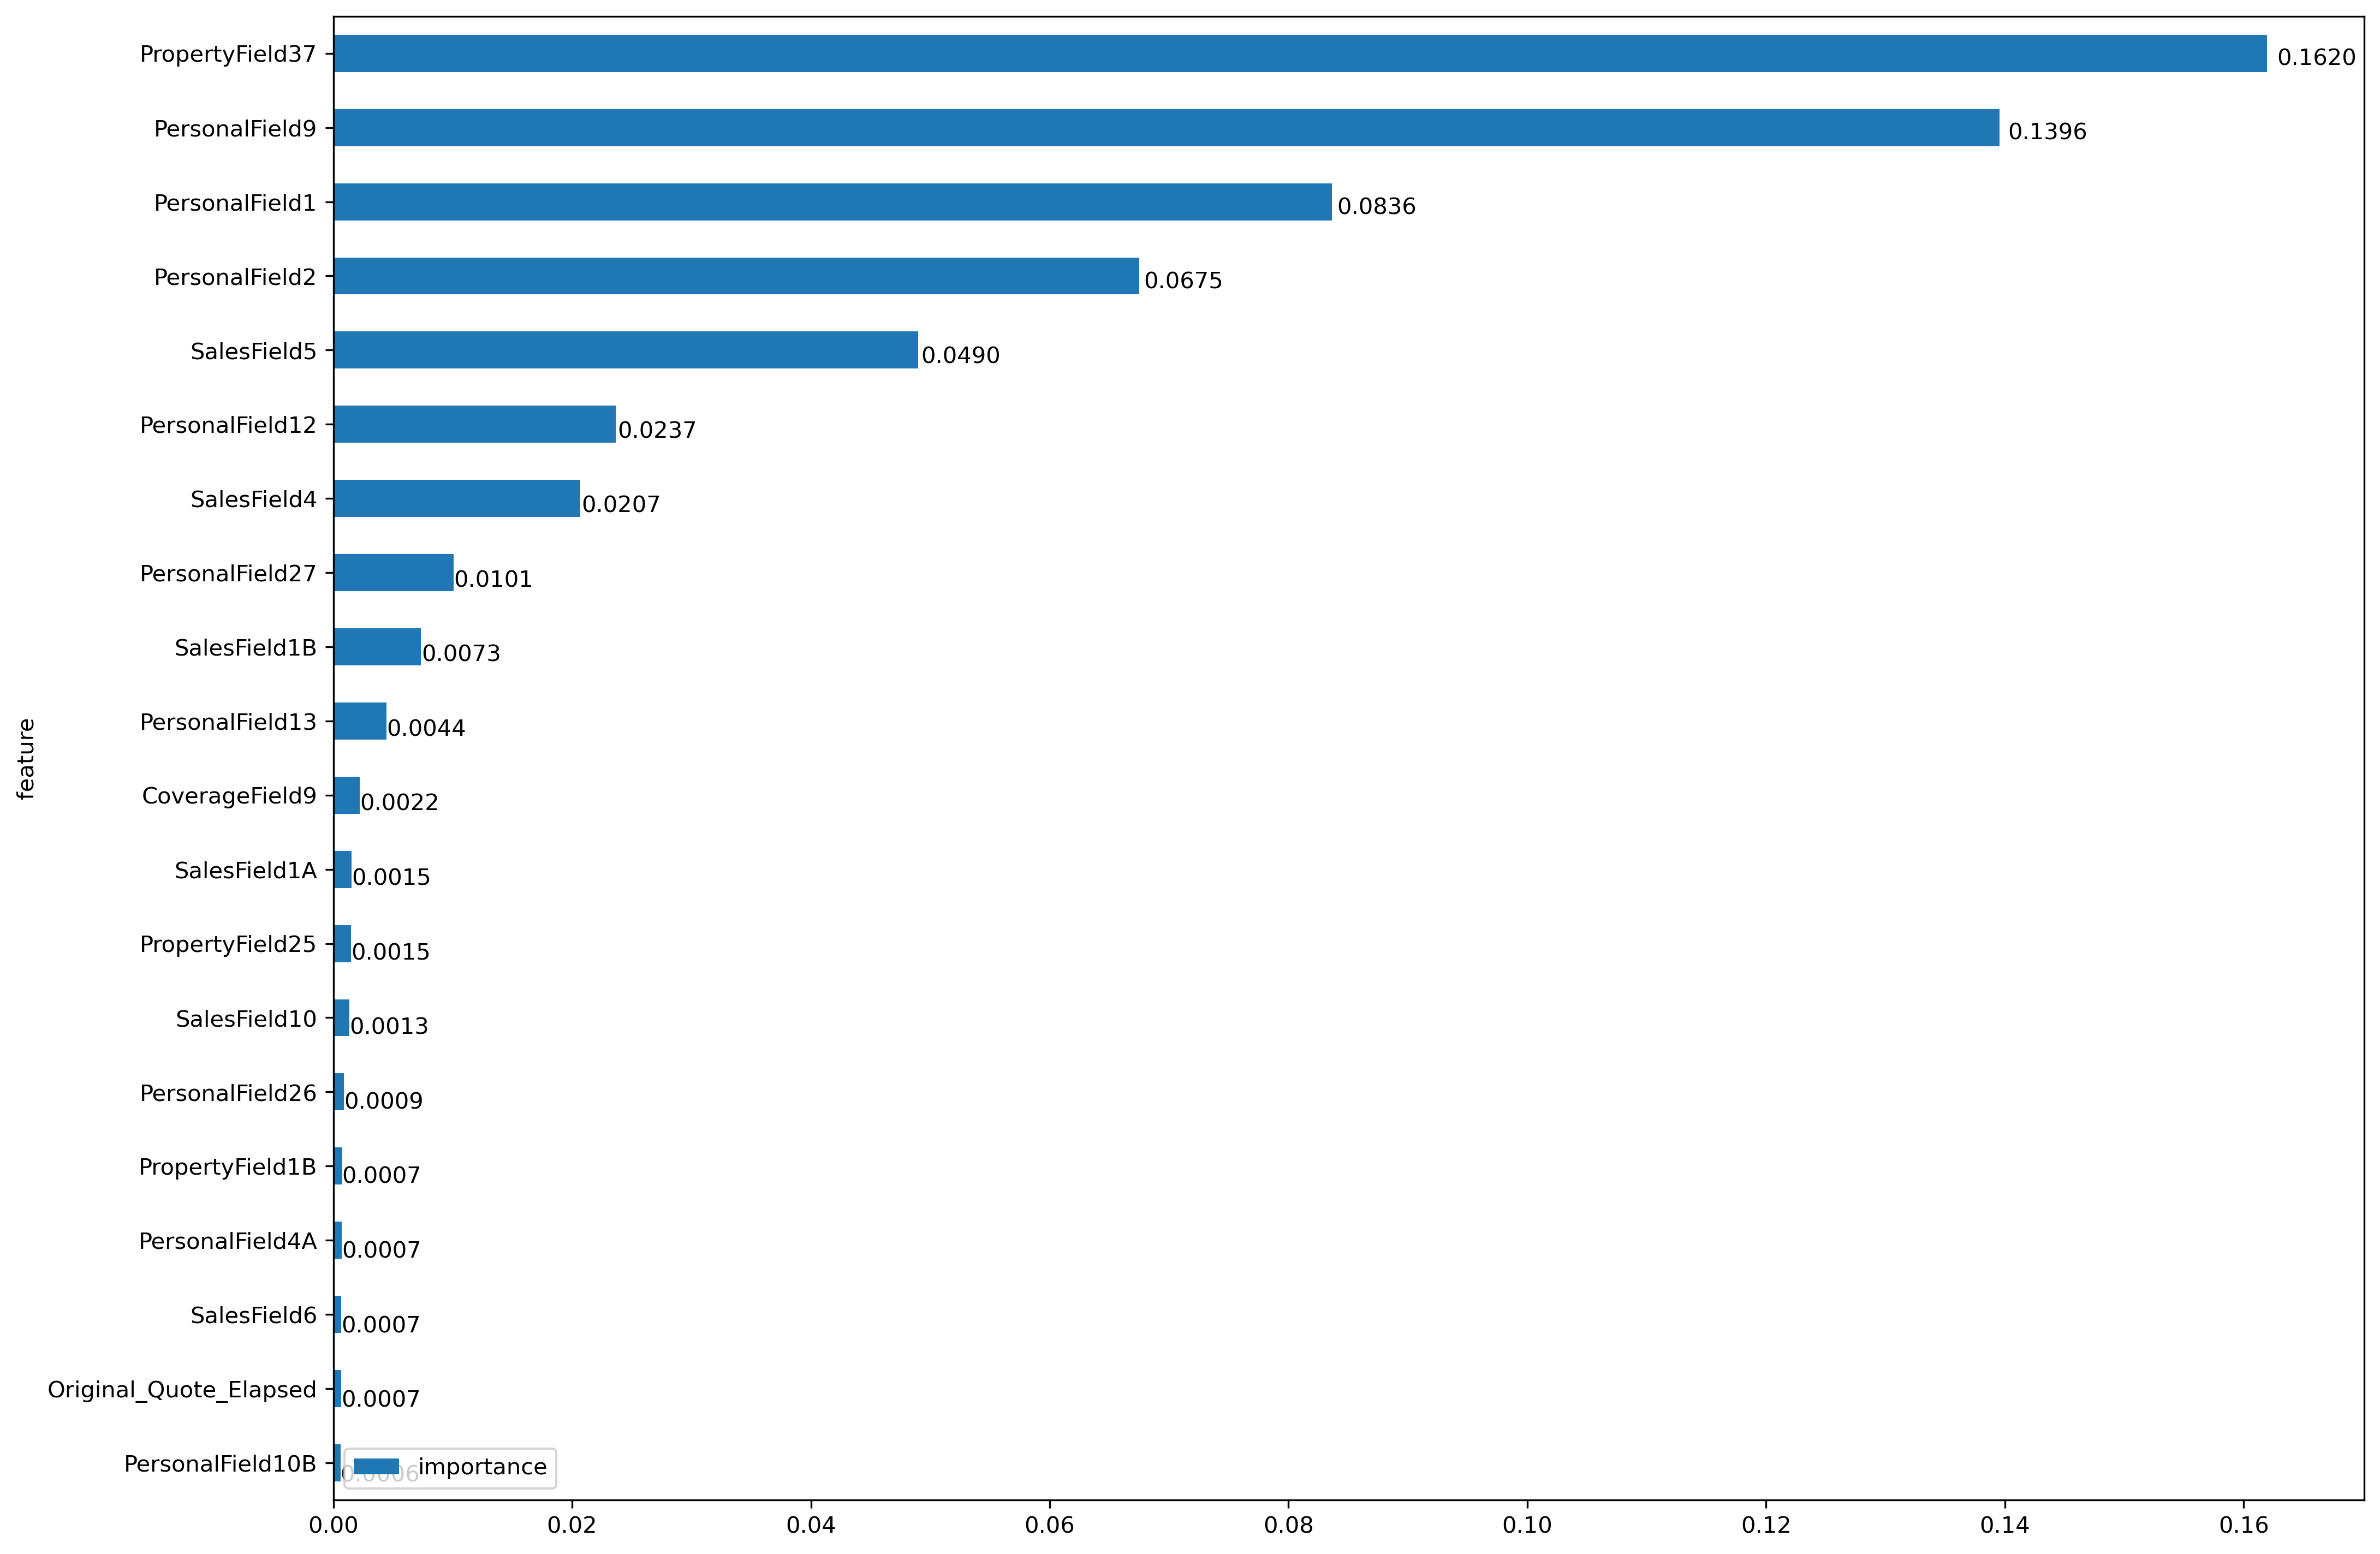

In [74]:
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['figure.dpi'] = 300
res = PermutationImportance(learn)

#### Results from the permutation importance

In [75]:
# The results are saved in a dictionary 
permutation_importance = res.importance

As the results are in a dictionary, we need to extract the data. This notebook shows two ways of getting the data:

In [76]:
# First way
# to access the values, we need to convert them into a list 
perm_imp_items = list(permutation_importance.items())

In [77]:
len(perm_imp_items)

300

In [78]:
perm_imp_items[10]

('SalesField4', 0.020698971844108835)

In [79]:
permutation_importance_df = pd.DataFrame(perm_imp_items, columns=['Keys', 'Values'])
permutation_importance_df

,Keys,Values
0,Field6,0.000116
1,Field10,0.000050
2,Field12,0.000050
3,CoverageField5A,-0.000066
4,CoverageField5B,0.000266
...,...,...
295,GeographicField61B,0.000233
296,Original_Quote_Week,-0.000050
297,Original_Quote_Day,0.000017
298,Original_Quote_Dayofyear,0.000133


In [80]:
# Seconda way
# Or we can access to the values in a separate way by extracting the data from the dictionary
features = list(permutation_importance.keys())
values = list(permutation_importance.values())

In [81]:
len(features), len(values)

(300, 300)

In [82]:
features[10], values[10]

('SalesField4', 0.020698971844108835)

Both approaches have the same result. 

In [83]:
permutation_importance_df = pd.DataFrame(list(zip(features,values)), columns=['Features', 'Values'])
permutation_importance_df

,Features,Values
0,Field6,0.000116
1,Field10,0.000050
2,Field12,0.000050
3,CoverageField5A,-0.000066
4,CoverageField5B,0.000266
...,...,...
295,GeographicField61B,0.000233
296,Original_Quote_Week,-0.000050
297,Original_Quote_Day,0.000017
298,Original_Quote_Dayofyear,0.000133


Now that we have the dataframe, we will sort the data to get the columns that are more relevant according to the permutation importance

In [84]:
# visualise if we sort them
permutation_importance_df1 = permutation_importance_df.sort_values('Values', ascending=False)
permutation_importance_df1

,Features,Values
119,PropertyField37,0.161967
24,PersonalField9,0.139556
19,PersonalField1,0.083644
20,PersonalField2,0.067517
11,SalesField5,0.048963
...,...,...
164,SalesField2B,-0.000283
116,PropertyField31,-0.000332
118,PropertyField35,-0.000382
169,PersonalField4B,-0.000416


In [85]:
# Get the first 30 columns
permut_selected_columns_df =  permutation_importance_df1[0:30]
permut_selected_columns_df

,Features,Values
119,PropertyField37,0.161967
24,PersonalField9,0.139556
19,PersonalField1,0.083644
20,PersonalField2,0.067517
11,SalesField5,0.048963
...,...,...
160,CoverageField11B,0.000482
97,PropertyField7,0.000449
155,CoverageField3A,0.000449
163,SalesField2A,0.000449


In [86]:
# Get the columns according with a threshold
permut_selected_columns_df = permutation_importance_df1.query('Values > 0.001')
permut_selected_columns_df

,Features,Values
119,PropertyField37,0.161967
24,PersonalField9,0.139556
19,PersonalField1,0.083644
20,PersonalField2,0.067517
11,SalesField5,0.048963
26,PersonalField12,0.023675
10,SalesField4,0.020699
37,PersonalField27,0.010059
162,SalesField1B,0.007349
27,PersonalField13,0.004439


In [87]:
fastai_permut_columns = permut_selected_columns_df.Features.values
fastai_permut_columns

array(['PropertyField37', 'PersonalField9', 'PersonalField1',
       'PersonalField2', 'SalesField5', 'PersonalField12', 'SalesField4',
       'PersonalField27', 'SalesField1B', 'PersonalField13',
       'CoverageField9', 'SalesField1A', 'PropertyField25',
       'SalesField10'], dtype=object)

## Feature importance for XGBoost

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

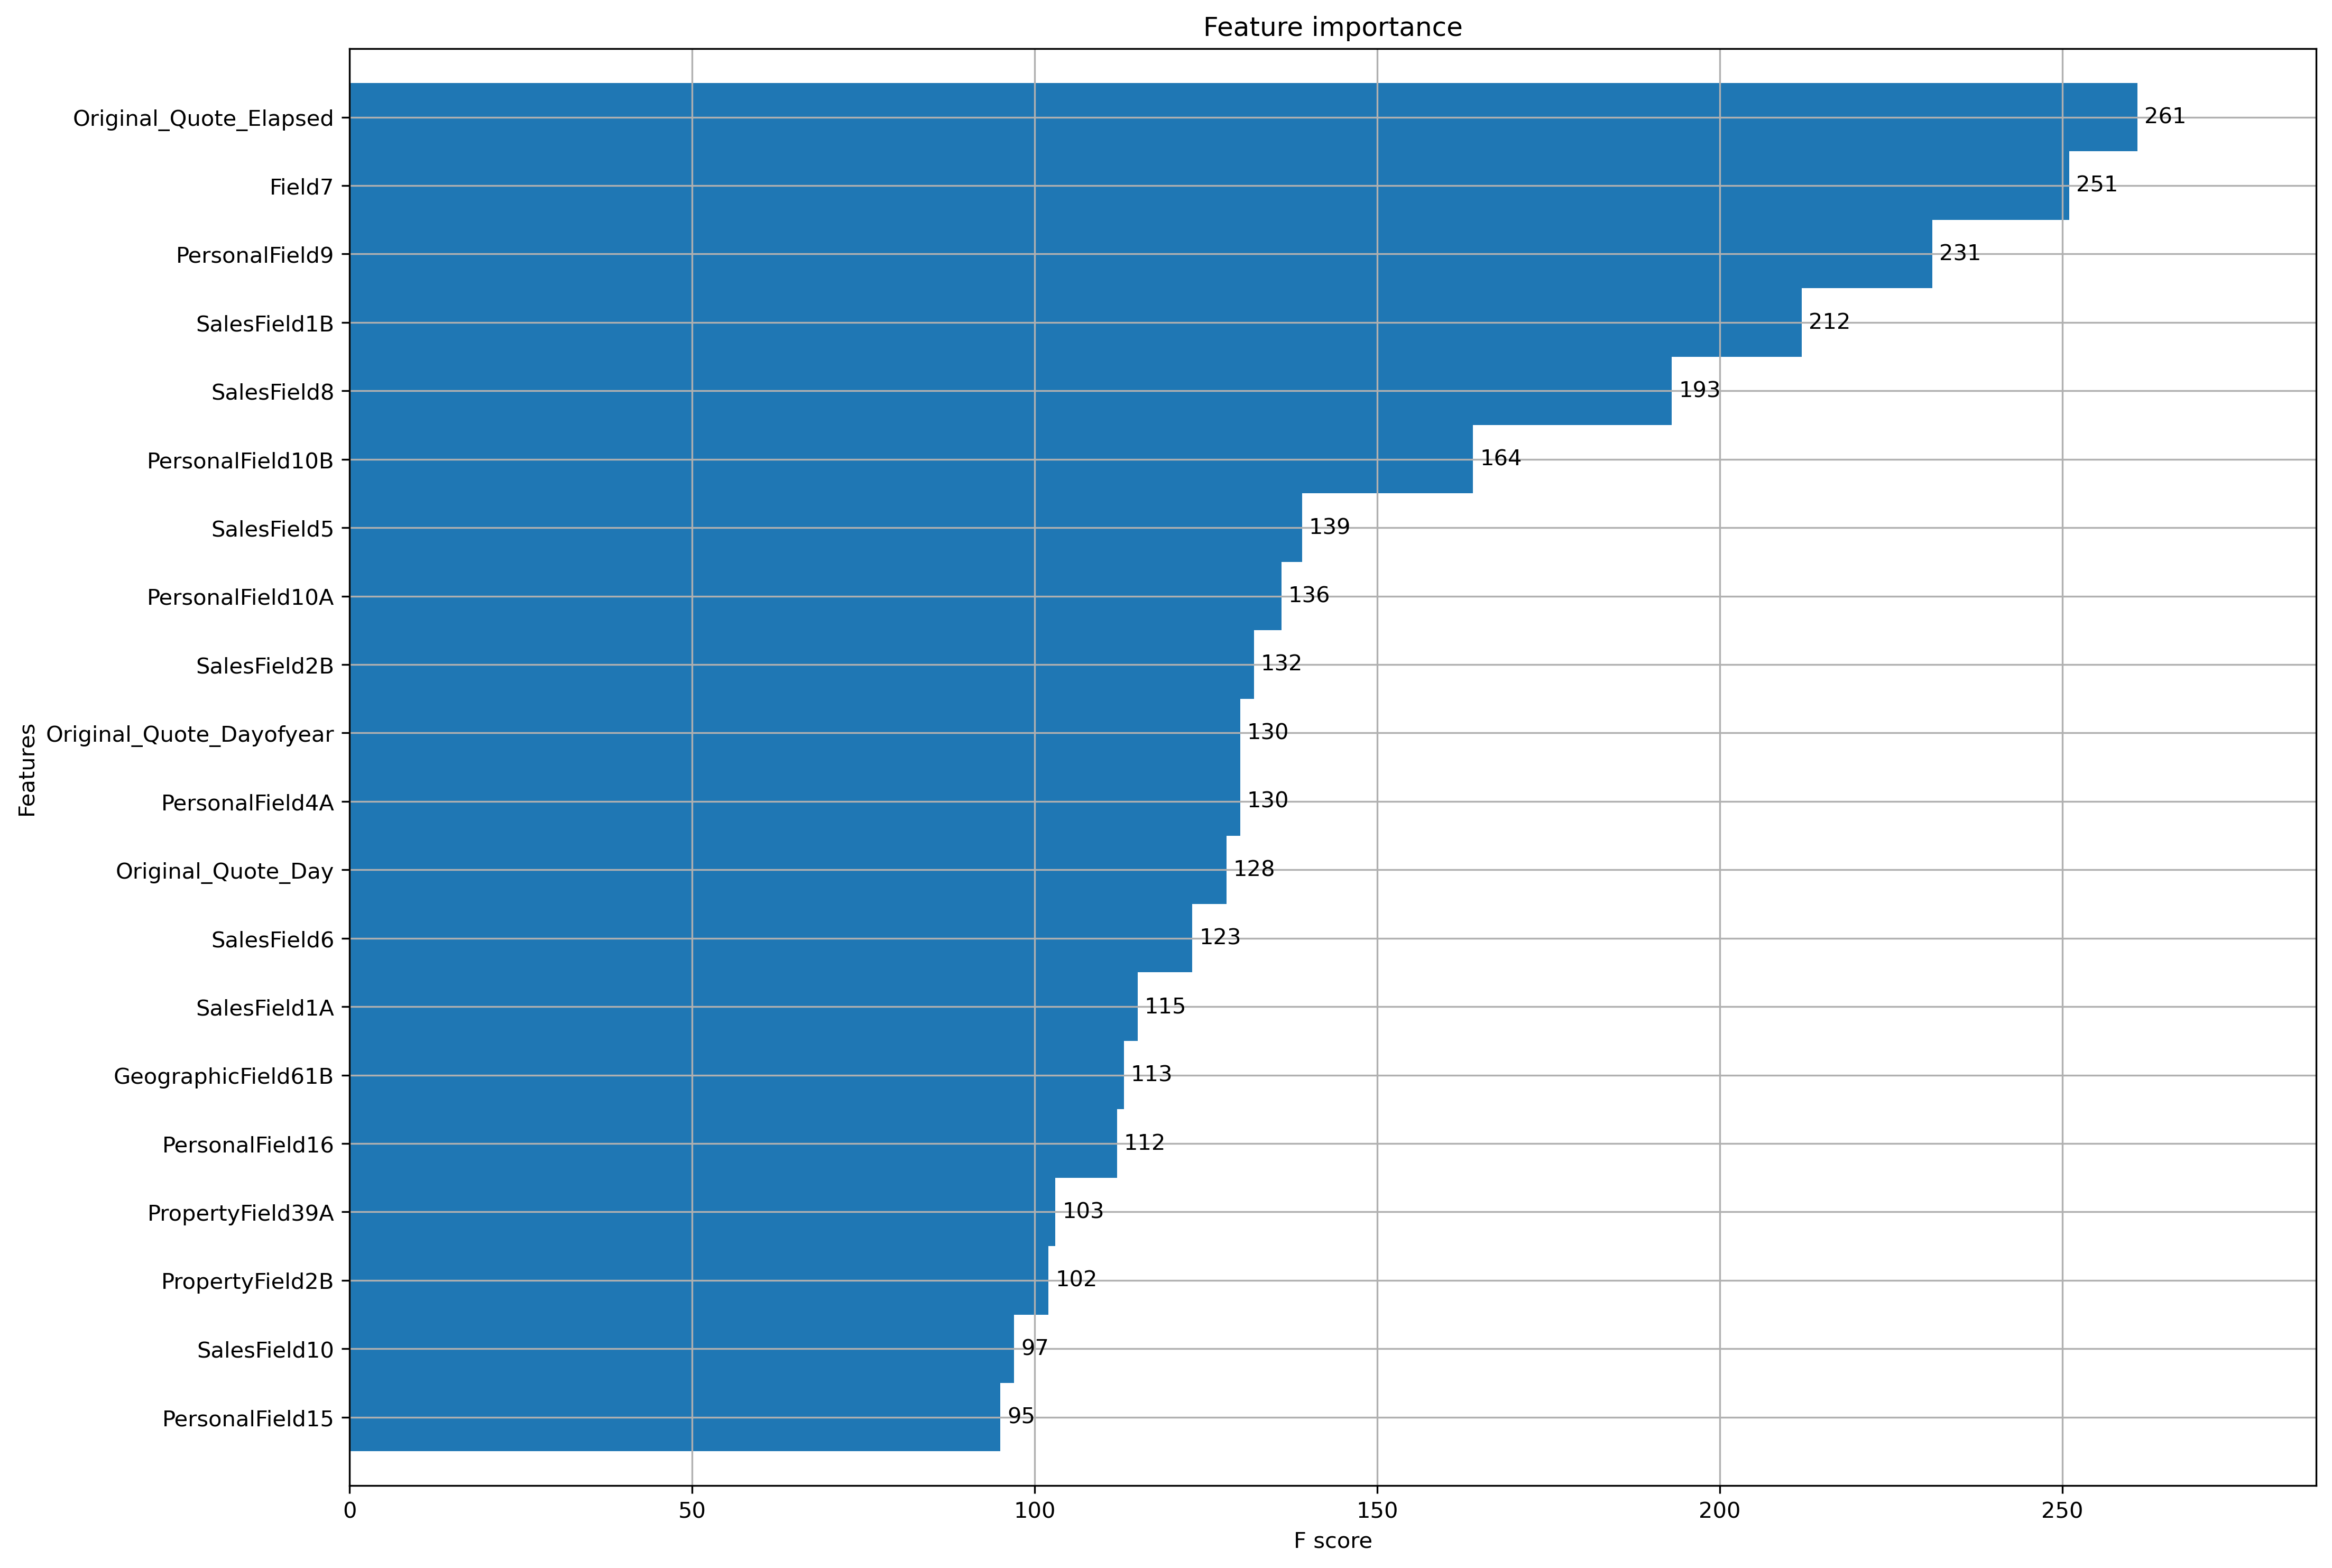

In [88]:
plot_importance(xgb_model, height=1,max_num_features=20)

In [89]:
feat_importance = model.get_booster().get_score(importance_type='weight')
features = list(feat_importance.keys())
values = list(feat_importance.values())

In [90]:
len(features), len(values)

(249, 249)

In [91]:
feat_importance_df = pd.DataFrame(list(zip(features,values)), columns=['Features', 'Values'])
feat_importance_df

,Features,Values
0,SalesField5,139
1,PersonalField9,231
2,PropertyField37,82
3,PersonalField1,73
4,SalesField1B,212
...,...,...
244,SalesField15,2
245,Original_Quote_Is_month_start,1
246,SalesField13,3
247,GeographicField23A,1


In [92]:
# visualise if we sort them
feat_importance_df.sort_values('Values', ascending=False)

,Features,Values
93,Original_Quote_Elapsed,261
6,Field7,251
1,PersonalField9,231
4,SalesField1B,212
31,SalesField8,193
...,...,...
234,PersonalField62,1
143,PropertyField10,1
245,Original_Quote_Is_month_start,1
247,GeographicField23A,1


In [93]:
new_feat_importance_df = feat_importance_df.query('Values > 60')
new_feat_importance_df

,Features,Values
0,SalesField5,139
1,PersonalField9,231
2,PropertyField37,82
3,PersonalField1,73
4,SalesField1B,212
...,...,...
155,GeographicField1B,66
181,PropertyField1A,94
187,GeographicField60B,72
201,Original_Quote_Dayofweek,62


In [94]:
xgb_feat_cols = new_feat_importance_df.Features.values
xgb_feat_cols

array(['SalesField5', 'PersonalField9', 'PropertyField37',
       'PersonalField1', 'SalesField1B', 'Field7', 'PersonalField10B',
       'CoverageField8', 'PersonalField10A', 'SalesField1A',
       'PersonalField27', 'CoverageField11A', 'PersonalField4A',
       'SalesField4', 'SalesField2A', 'PersonalField18',
       'GeographicField62B', 'SalesField2B', 'SalesField8',
       'GeographicField35B', 'PropertyField24A', 'PropertyField39A',
       'Original_Quote_Day', 'PersonalField15', 'PropertyField2B',
       'GeographicField37A', 'GeographicField4A', 'SalesField10',
       'GeographicField18B', 'PersonalField17', 'GeographicField57A',
       'PropertyField39B', 'SalesField7', 'SalesField6',
       'Original_Quote_Elapsed', 'PersonalField16', 'GeographicField61B',
       'GeographicField39A', 'GeographicField56B', 'PersonalField4B',
       'SalesField3', 'Original_Quote_Dayofyear', 'CoverageField6A',
       'PropertyField26A', 'GeographicField58B', 'GeographicField58A',
       'Geogra

# Feature importance for RF

The library, rfpipm, provides features importances based upon the permutation importance strategy.

Following [Nissan's](https://redditech.github.io/team-fast-tabulous/kaggle/fastai/2021/06/29/Permutation-Importance-And-Ensemble-Experiment.html) approach:

In [95]:
from rfpimp import *

C:\Users\ML\.conda\envs\fastai\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


We will use to_train.valid.ys to keep the same idx as the X_valid data

In [96]:
# This dataframe has the quote_number as idx
y_valid = to_train.valid.ys
imp_RF_df = importances(rfc, X_valid_rf, y_valid)
imp_RF_df

,Importance
Feature,
PropertyField37,0.1054
PersonalField1,0.0170
SalesField5,0.0158
PersonalField10A,0.0088
PersonalField2,0.0084
...,...
PropertyField1A,-0.0008
GeographicField26A,-0.0008
CoverageField9,-0.0010


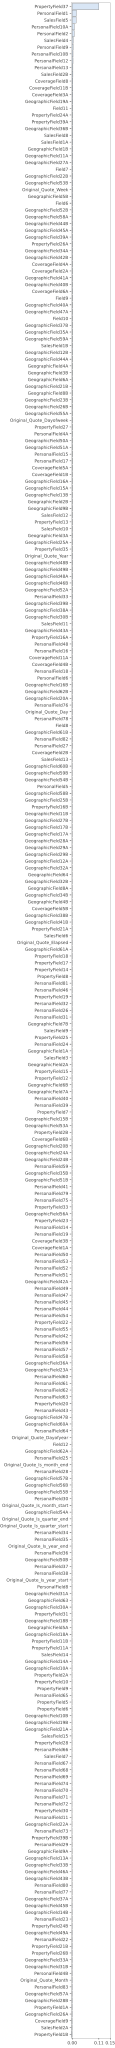

In [97]:
plot_importances(imp_RF_df)

In [98]:
imp_RF_df = imp_RF_df.query('Importance > 0.001')
imp_RF_df

,Importance
Feature,
PropertyField37,0.1054
PersonalField1,0.0170
SalesField5,0.0158
PersonalField10A,0.0088
PersonalField2,0.0084
...,...
GeographicField50A,0.0010
GeographicField51A,0.0010
PersonalField15,0.0010


In [99]:
imp_RF_df = imp_RF_df.reset_index()
RF_feat_cols = imp_RF_df.Feature.values
RF_feat_cols

array(['PropertyField37', 'PersonalField1', 'SalesField5',
       'PersonalField10A', 'PersonalField2', 'SalesField4',
       'PersonalField9', 'PersonalField10B', 'PersonalField12',
       'PersonalField13', 'SalesField2B', 'CoverageField8',
       'CoverageField11B', 'CoverageField3A', 'GeographicField19A',
       'Field11', 'PropertyField24A', 'PropertyField39A',
       'GeographicField36B', 'SalesField8', 'SalesField1A',
       'GeographicField1B', 'GeographicField11A', 'GeographicField27A',
       'Field7', 'GeographicField22B', 'GeographicField53B',
       'Original_Quote_Week', 'GeographicField5B', 'Field6',
       'GeographicField52B', 'GeographicField58A', 'GeographicField44B',
       'GeographicField45A', 'GeographicField39A', 'PropertyField26A',
       'GeographicField34A', 'GeographicField42B', 'CoverageField4A',
       'CoverageField2A', 'GeographicField41A', 'GeographicField40B',
       'CoverageField6A', 'Field9', 'GeographicField40A',
       'GeographicField47A', 'Field

# Most relevant columns from each model

#### We will use the columns from the perumation and feature importance to train the models and compare them between them

In [100]:
len(fastai_permut_columns), len(xgb_feat_cols), len(RF_feat_cols)

(14, 54, 69)

In [101]:
# Append the data
col_list = []

feats= [fastai_permut_columns, xgb_feat_cols, RF_feat_cols]

for data in feats:
    for col in data:
        col_list.append(col)

In [102]:
len(col_list)

137

#### We need to add the target column to the train set, I.e. 'QuoteConversion_Flag'

In [103]:
# Reminder for myself: we need to create an explicit copy of the list, because if we don't do that we will be altering
# a mutable variable
train_col_list = list(col_list)
train_col_list.append('QuoteConversion_Flag')
test_col_list = list(col_list)
len(train_col_list), len(test_col_list)

(138, 137)

In [104]:
# To eliminate the duplicates we'll convert the list to a dictionary, as dictionaries can't have duplicate keys.
# Then we'll convert the dicitonary again to a list 
train_col_list = list(dict.fromkeys(train_col_list))
test_col_list = list(dict.fromkeys(test_col_list))
len(train_col_list), len(test_col_list)

(98, 97)

# Create a dataframe with the columns selected by permutation and feature importances

In [105]:
# veryfying that the nothing hasn't changed
# original data
X_train_fastai.columns.size, X_test_fastai.columns.size

(301, 300)

In [106]:
X_train_fastai.QuoteConversion_Flag

QuoteNumber
1         0
2         0
4         0
6         0
8         0
         ..
434584    0
434585    0
434586    0
434587    0
434588    0
Name: QuoteConversion_Flag, Length: 260753, dtype: int64

In [107]:
# Keeping the columns that are relevant according to the permutation and feature importances 
X_train_fastai_ = X_train_fastai[train_col_list]
X_test_fastai_ = X_test_fastai[test_col_list]

In [108]:
X_train_fastai_

,PropertyField37,PersonalField9,PersonalField1,PersonalField2,...,GeographicField50A,GeographicField51A,CoverageField5A,QuoteConversion_Flag
QuoteNumber,,,,,,,,,
1,N,2,0,0,...,16,21,13,0
2,N,2,1,1,...,20,13,13,0
4,N,2,1,1,...,20,18,25,0
6,Y,3,1,1,...,18,13,13,0
8,N,2,1,1,...,17,25,13,0
...,...,...,...,...,...,...,...,...,...
434584,N,2,1,1,...,20,10,13,0
434585,Y,3,1,1,...,23,10,25,0
434586,Y,3,1,1,...,15,16,13,0


In [109]:
# get the continuous and categorical columns
# Our target column is "QuoteConversion_Flag"
cont_names, cat_names = cont_cat_split(X_train_fastai_, dep_var='QuoteConversion_Flag')

# check if the number of columns is correct
# as we used the quote number as the idx and the target data, 
# for instance: we should get (total_columns - 1) = 300 columns for the train set 
len(cont_names), len(cat_names)

(71, 26)

In [110]:
# check if the target column is not in the categorical or continous columns
"QuoteConversion_Flag" in cont_names, "QuoteConversion_Flag" in cat_names

(False, False)

# Results with selected columns

## FastAI tabular learner

In [111]:
# create the data loaders for tabular fastai
target_column = 'QuoteConversion_Flag'

# some parameters for the data loader function
random_seed = 42
set_seed(random_seed)
batch_size = 1024
layers = [250, 500, 1000]
dropout = [0.2, 0.2, 0.2]
emb_dropout=0.02
test_size = 0.25

procs = [Categorify, FillMissing, Normalize]
splits_ = TrainTestSplitter(test_size=test_size, stratify=X_train_fastai_[target_column])(X_train_fastai_)

to_train_ = TabularPandas(df=X_train_fastai_, 
                   procs=procs,
                   cat_names=cat_names, 
                   cont_names=cont_names,
                   y_names=target_column,
                   splits=splits_,
                   y_block=CategoryBlock())



dls_ = to_train_.dataloaders(bs=batch_size, val_bs=batch_size, layers=layers, embed_ps=emb_dropout, ps=dropout)
dls_.valid.show_batch()

,PropertyField37,PersonalField9,PersonalField1,PersonalField2,SalesField5,PersonalField12,SalesField4,PersonalField27,PersonalField13,CoverageField9,SalesField10,CoverageField8,PersonalField18,GeographicField62B,PersonalField17,SalesField7,PersonalField16,SalesField3,CoverageField6A,Original_Quote_Dayofweek,GeographicField22B,GeographicField5B,Field6,Field10,PropertyField27,CoverageField5A,SalesField1B,SalesField1A,PropertyField25,Field7,PersonalField10B,PersonalField10A,CoverageField11A,PersonalField4A,SalesField2A,SalesField2B,SalesField8,GeographicField35B,PropertyField24A,PropertyField39A,Original_Quote_Day,PersonalField15,PropertyField2B,GeographicField37A,GeographicField4A,GeographicField18B,GeographicField57A,PropertyField39B,SalesField6,Original_Quote_Elapsed,GeographicField61B,GeographicField39A,GeographicField56B,PersonalField4B,Original_Quote_Dayofyear,PropertyField26A,GeographicField58B,GeographicField58A,GeographicField37B,Original_Quote_Week,CoverageField11B,GeographicField1B,PropertyField1A,GeographicField60B,GeographicField57B,CoverageField3A,GeographicField19A,Field11,GeographicField36B,GeographicField11A,GeographicField27A,GeographicField53B,GeographicField52B,GeographicField44B,GeographicField45A,GeographicField34A,GeographicField42B,CoverageField4A,CoverageField2A,GeographicField41A,GeographicField40B,Field9,GeographicField40A,GeographicField47A,GeographicField35A,GeographicField59A,GeographicField12B,GeographicField44A,GeographicField3B,GeographicField6A,GeographicField21B,GeographicField8B,GeographicField23B,GeographicField26B,GeographicField55A,GeographicField50A,GeographicField51A,QuoteConversion_Flag
0,N,2,1,1,5,1,5,1,2,D,1,T,XR,12,ZE,K,ZA,1,13,0,15,13,B,935,4,13,19.0,8.0,3.0,23.0,18.0,9.0,1.0,3.0,2.0,4.0,42316.000014,9.0,18.0,3.0,10.0,24.0,17.0,7.0,25.0,9.0,6.0,2.0,11.0,1.391990e+09,12.0,8.000000,21.0,3.0,40.999994,7.0,4.0,6.0,17.0,6.999999,1.0,15.0,4.0,16.0,3.0,22.000000,2.0,1.0200,4.0,2.0,15.0,8.0,20.0,17.0,2.0,6.000000,3.0,24.0,25.0,2.0,8.0,0.0007,3.0,21.000000,6.0,9.0,7.0,15.0,13.0,2.0,4.0,7.0,2.0,20.0,12.0,6.0,19.0,0
1,N,2,1,1,5,1,5,1,2,D,1,T,XR,24,ZE,Q,ZA,1,13,3,15,13,B,965,10,13,22.0,12.0,1.0,23.0,21.0,16.0,1.0,19.0,4.0,13.0,59943.999147,24.0,17.0,3.0,14.0,24.0,4.0,10.0,11.0,24.0,16.0,2.0,7.0,1.384387e+09,17.0,8.000000,21.0,23.0,317.999998,25.0,21.0,16.0,21.0,46.000001,1.0,21.0,17.0,6.0,19.0,21.000000,2.0,1.0200,22.0,2.0,15.0,4.0,3.0,16.0,2.0,13.000000,8.0,23.0,24.0,1.0,8.0,0.0006,3.0,7.000000,17.0,5.0,4.0,15.0,3.0,2.0,4.0,4.0,5.0,20.0,18.0,12.0,4.0,0
2,N,2,1,1,5,3,5,1,2,D,0,X,XR,12,ZE,Q,ZA,1,13,1,15,13,B,965,10,13,11.0,4.0,1.0,25.0,4.0,5.0,14.0,6.0,2.0,3.0,3553.999261,25.0,9.0,4.0,5.0,24.0,22.0,7.0,20.0,21.0,9.0,2.0,20.0,1.383610e+09,17.0,8.000000,19.0,8.0,308.999998,16.0,24.0,22.0,17.0,44.999999,22.0,14.0,6.0,7.0,6.0,12.000000,2.0,1.0200,6.0,2.0,17.0,3.0,10.0,9.0,3.0,6.000000,3.0,13.0,14.0,3.0,3.0,0.0006,2.0,25.000001,24.0,6.0,2.0,10.0,8.0,2.0,11.0,2.0,5.0,22.0,16.0,12.0,12.0,1
3,N,2,1,1,5,1,5,0,2,A,0,V,YP,8,XS,P,XR,1,25,6,23,13,C,"1,487",7,13,18.0,7.0,2.0,17.0,18.0,8.0,12.0,16.0,1.0,1.0,7220.998942,22.0,23.0,2.0,10.0,4.0,23.0,5.0,19.0,19.0,22.0,1.0,11.0,1.431216e+09,2.0,6.000000,9.0,20.0,130.000000,16.0,17.0,14.0,12.0,19.000000,21.0,7.0,6.0,24.0,24.0,25.000001,20.0,1.3045,13.0,9.0,6.0,19.0,23.0,20.0,10.0,10.000000,10.0,25.0,25.0,16.0,10.0,0.0006,5.0,6.000000,14.0,13.0,17.0,19.0,25.0,10.0,25.0,18.0,16.0,3.0,5.0,17.0,21.0,0
4,N,2,1,1,5,1,5,0,2,E,0,T,XF,17,XG,Q,XH,1,13,3,16,22,F,548,10,13,11.0,4.0,1.0,11.0,19.0,11.0,7.0,8.0,7.0,20.0,64502.998849,19.0,3.0,12.0,13.0,10.0,15.0,6.0,10.0,11.0,9.0,13.0,11.0,1.394669e+09,11.0,7.000000,18.0,10.0,71.999999,7.0,7.0,8.0,15.0,11.000000,14.0,7.0,8.0,5.0,5.0,2.000000,24.0,1.1886,4.0,4.0,25.0,2.0,9.0,12.0,8.0,7.000000,15.0,3.0,3.0,24.0,14.0,0.0040,9.0,7.000000,11.0,13.0,16.0,12.0,8.0,5.0,16.0,15.0,18.0,18.0,12.0,3.0,12.0,0
5,Y,3,1,1,5,5,5,1,2,D,0,T,XR,19,ZE,T,ZA,0,13,3,15,13,B,965,10,13,1.0,2.0,1.0,24.0,-1.0,-1.0,10.0,1.0,5.0,17.0,37300.000122,2.0,1.0,12.0,12

In [112]:
# As the metrics for the Kaggle challenge are defined for ROC AUC value, we will define it in the learner  
learn_ = tabular_learner(dls_,
                        metrics=[accuracy,
                                 RocAucBinary(),
                                 Recall(),
                                 Precision()],
                       )

SuggestedLRs(valley=tensor(0.0010), slide=tensor(0.0191), minimum=0.03019951581954956, steep=0.03981071710586548)

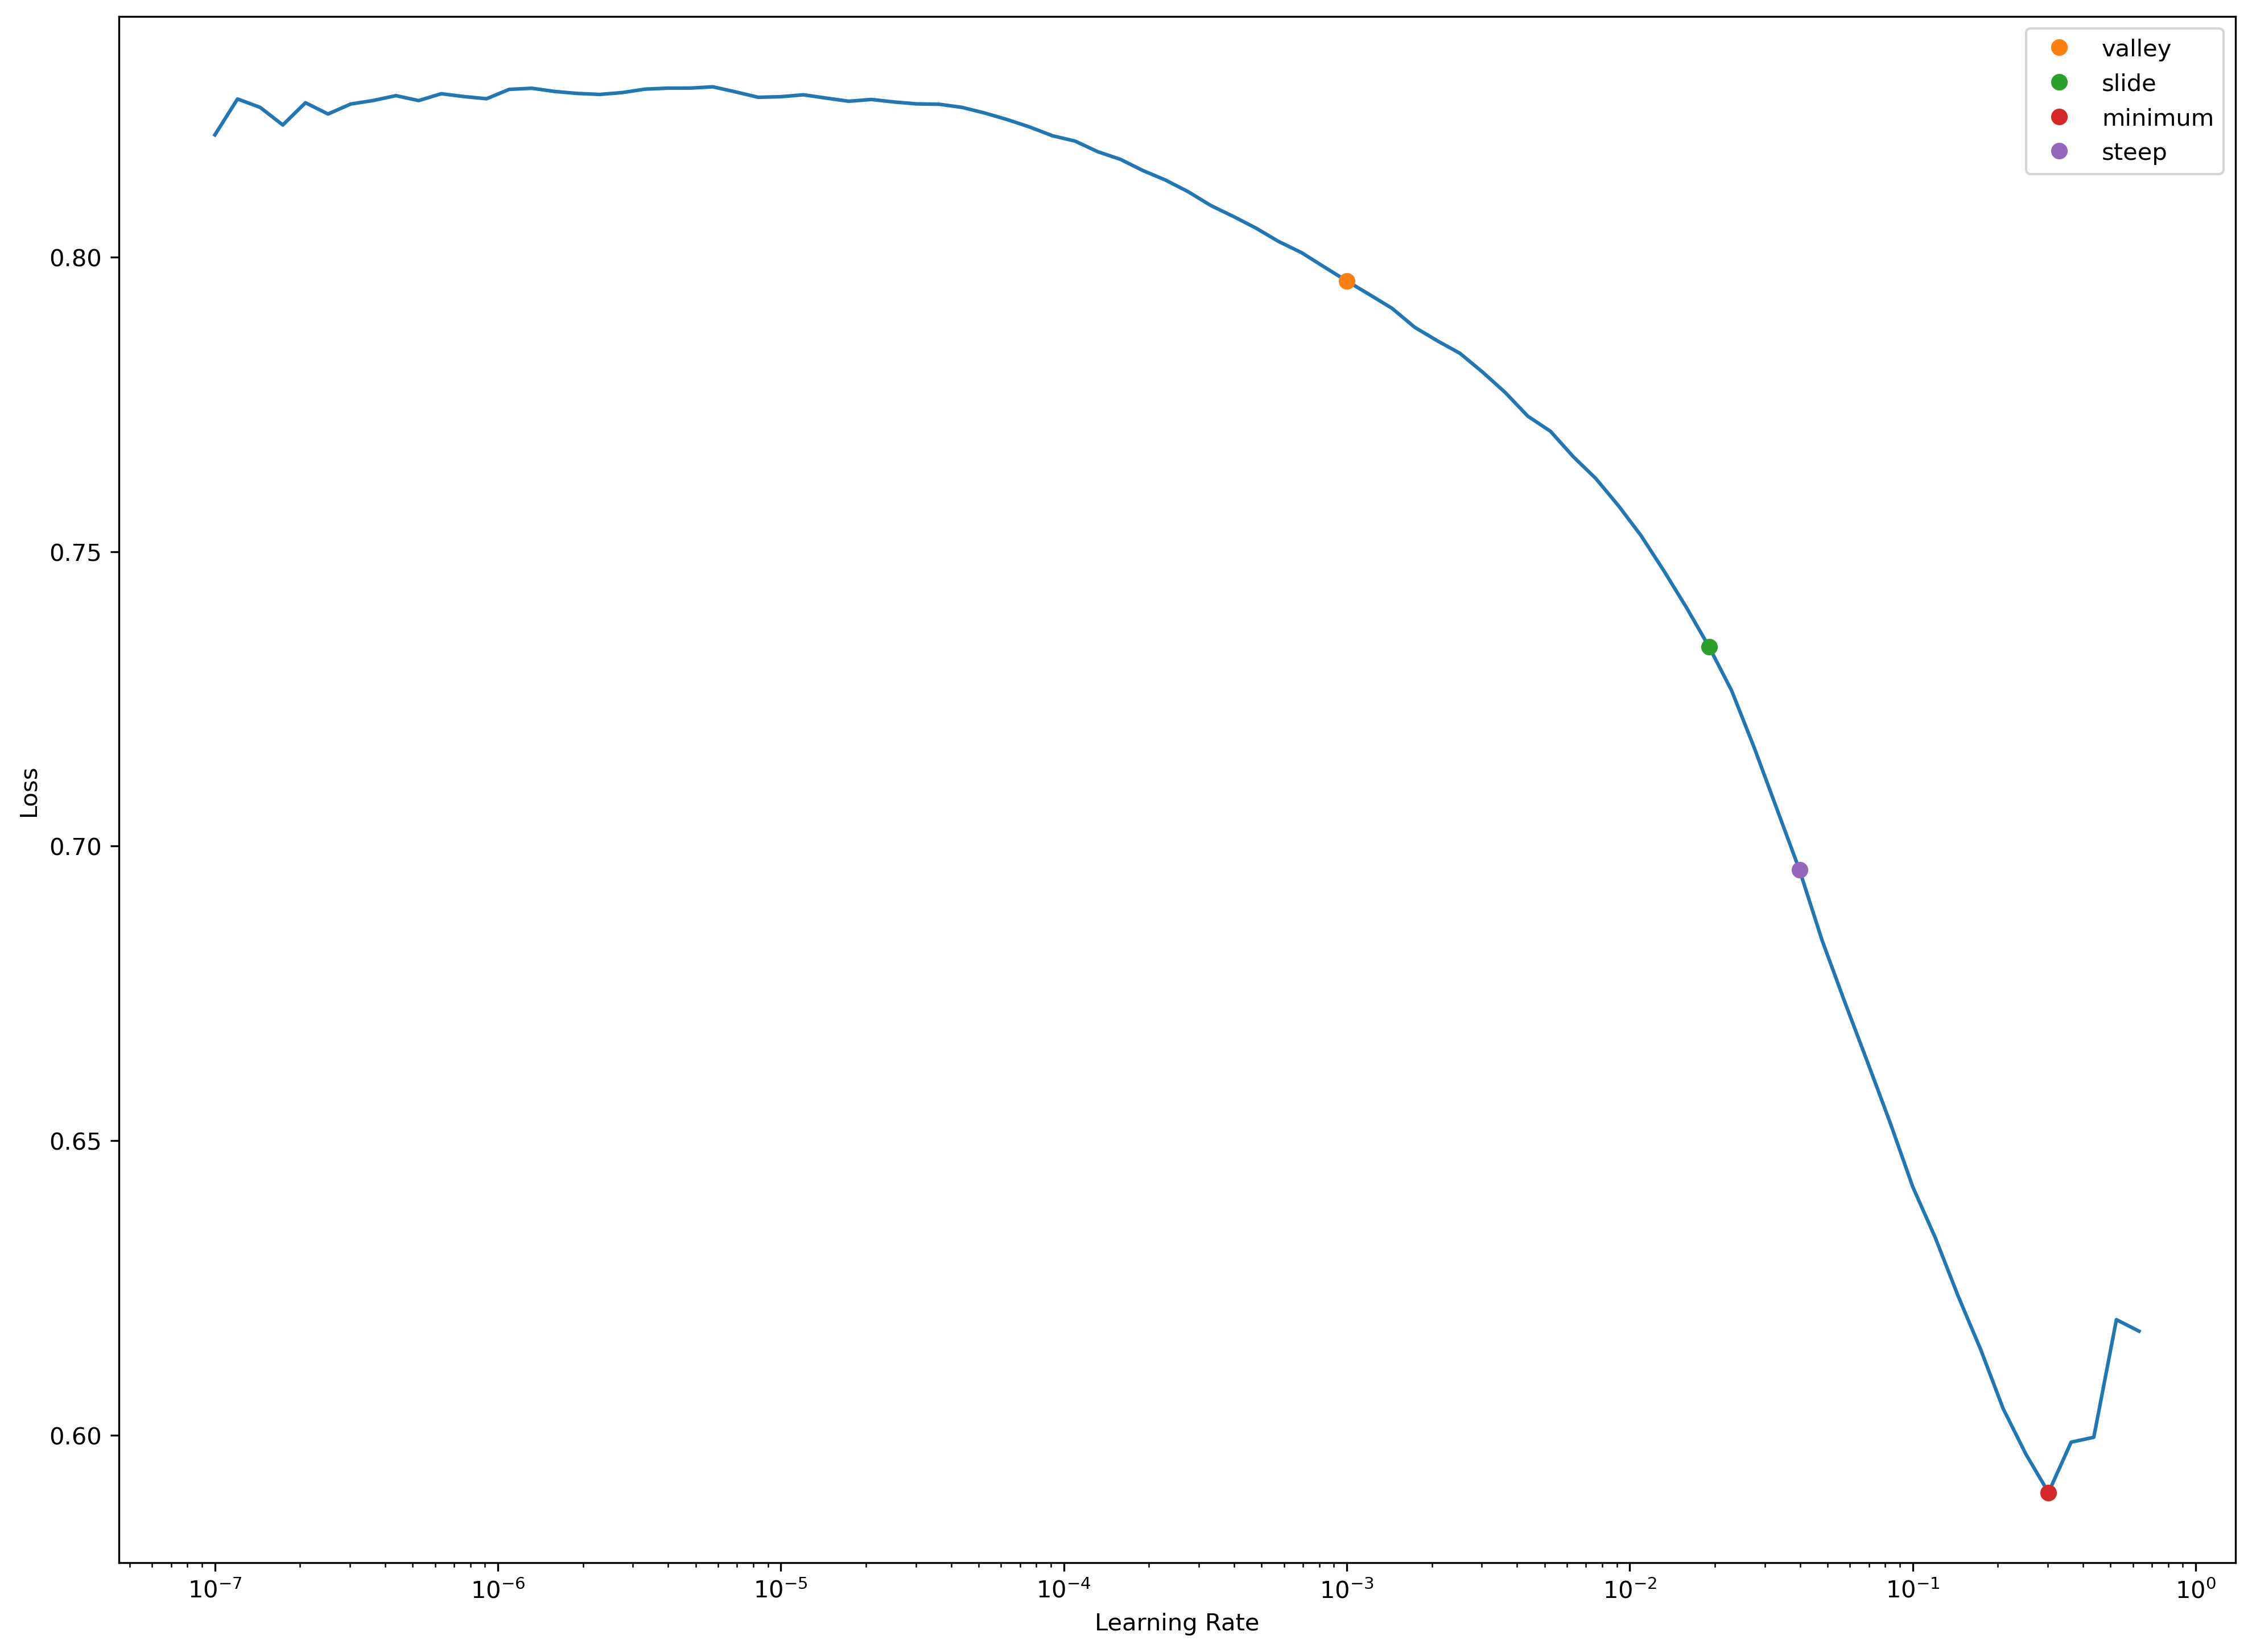

In [113]:
# With this line we will find and visualise different learning rates 
# and it might help to choose a good value 
learn_.lr_find(suggest_funcs=(valley, slide, minimum, steep))

epoch,train_loss,valid_loss,accuracy,roc_auc_score,recall_score,precision_score,time
0,0.224662,0.199345,0.915952,0.950785,0.699935,0.825311,00:15
1,0.192562,0.188077,0.919956,0.956511,0.716214,0.833492,00:15
2,0.183380,0.186144,0.919189,0.957443,0.711306,0.833333,00:15
3,0.178439,0.180840,0.923239,0.959208,0.668112,0.896094,00:15
4,0.169923,0.180357,0.923377,0.959638,0.684555,0.880194,00:15


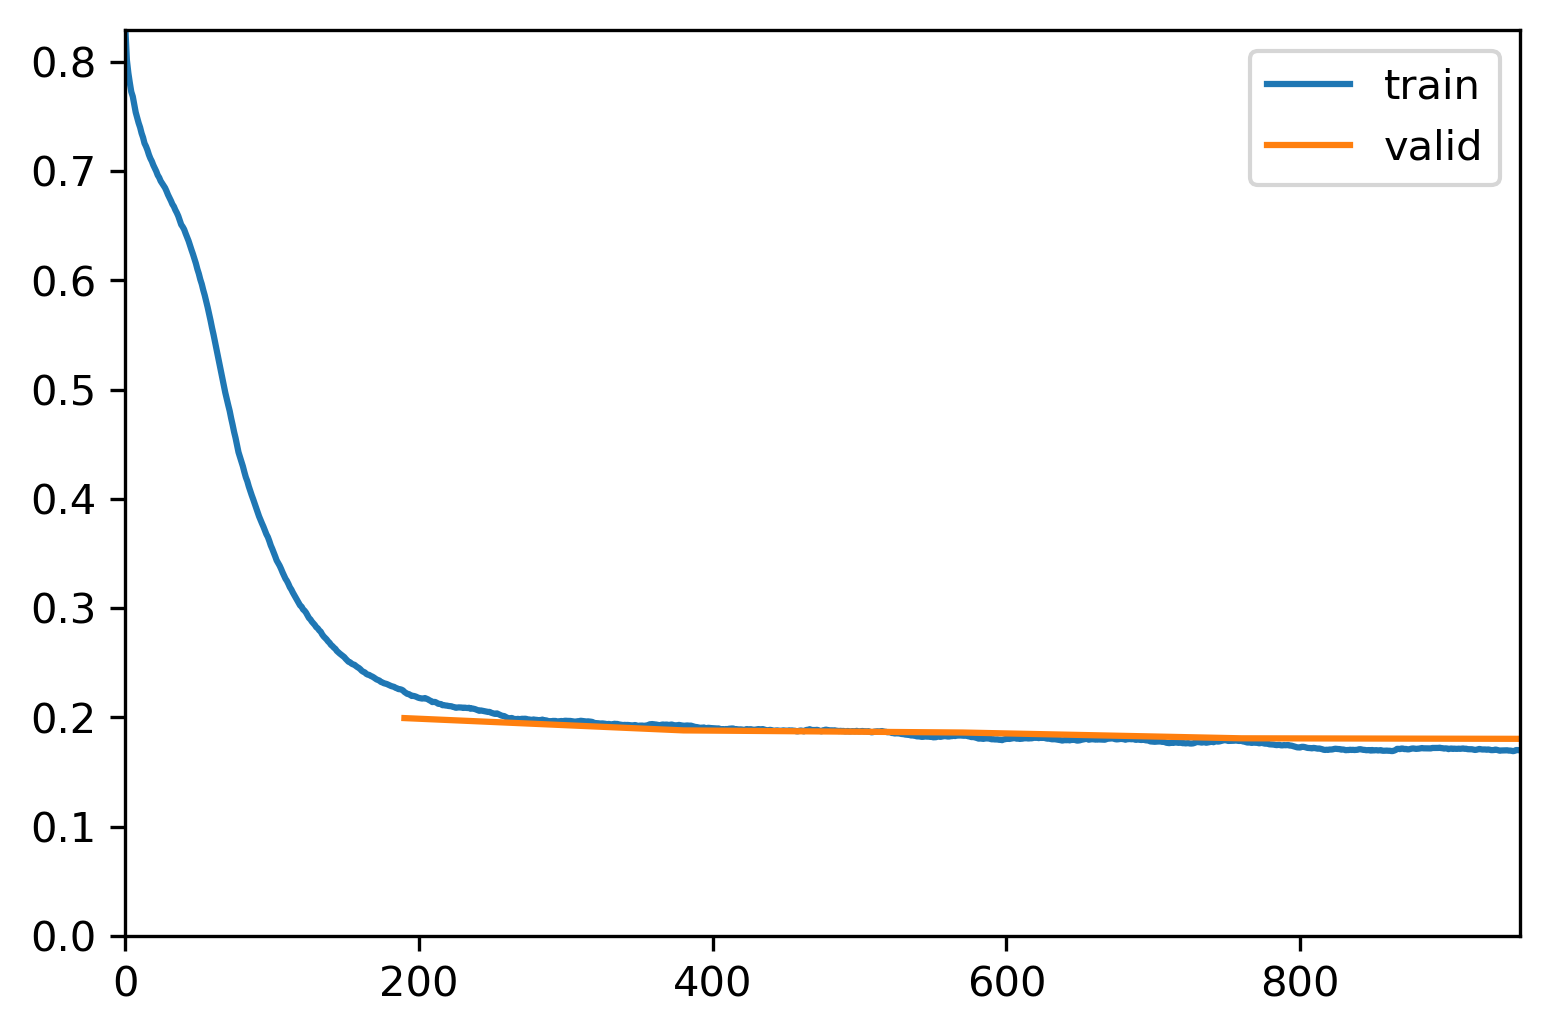

In [114]:
# define some parameters for the model
epochs = 5
lr = 0.0191
weight_decay = 0.002

learn_.fit_one_cycle(epochs,
                    lr, 
                    wd=weight_decay,
                    cbs=[ShowGraphCallback()]
                   )

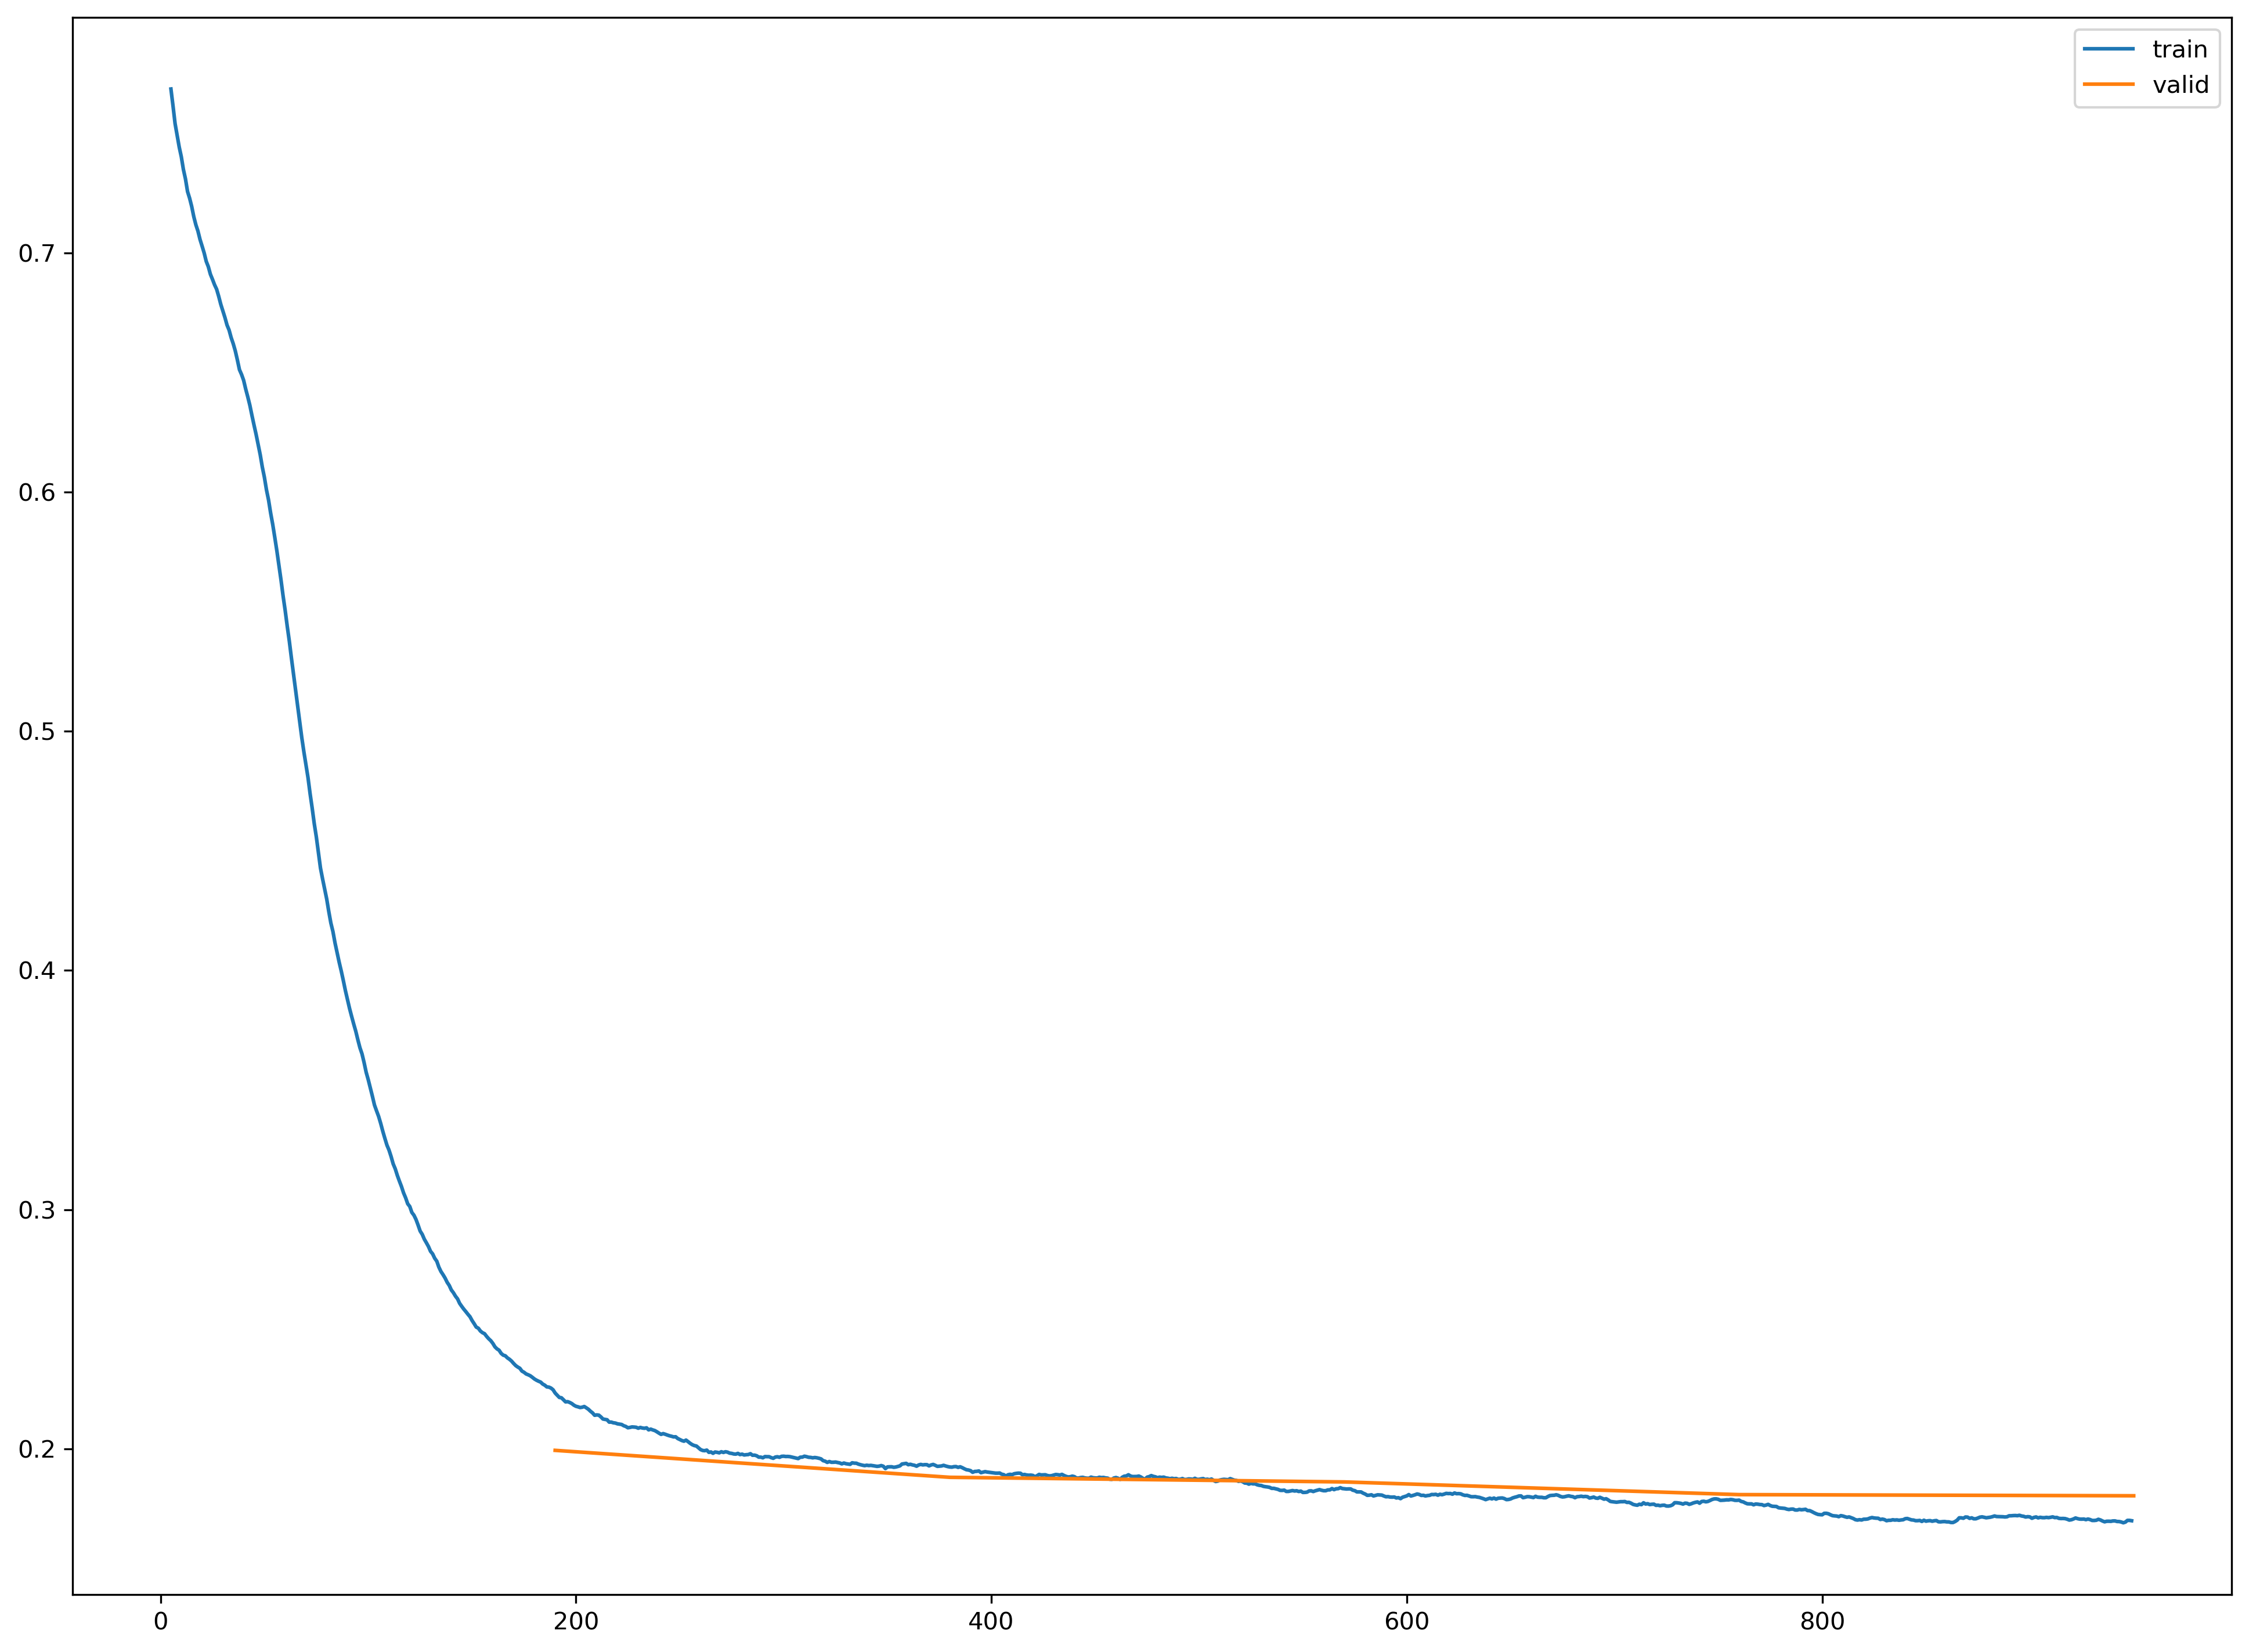

In [115]:
learn_.recorder.plot_loss()

In [116]:
interpretation_results_ = ClassificationInterpretation.from_learner(learn_)

In [117]:
interpretation_results_.confusion_matrix()

array([[51826,  1139],
       [ 3856,  8368]], dtype=int64)

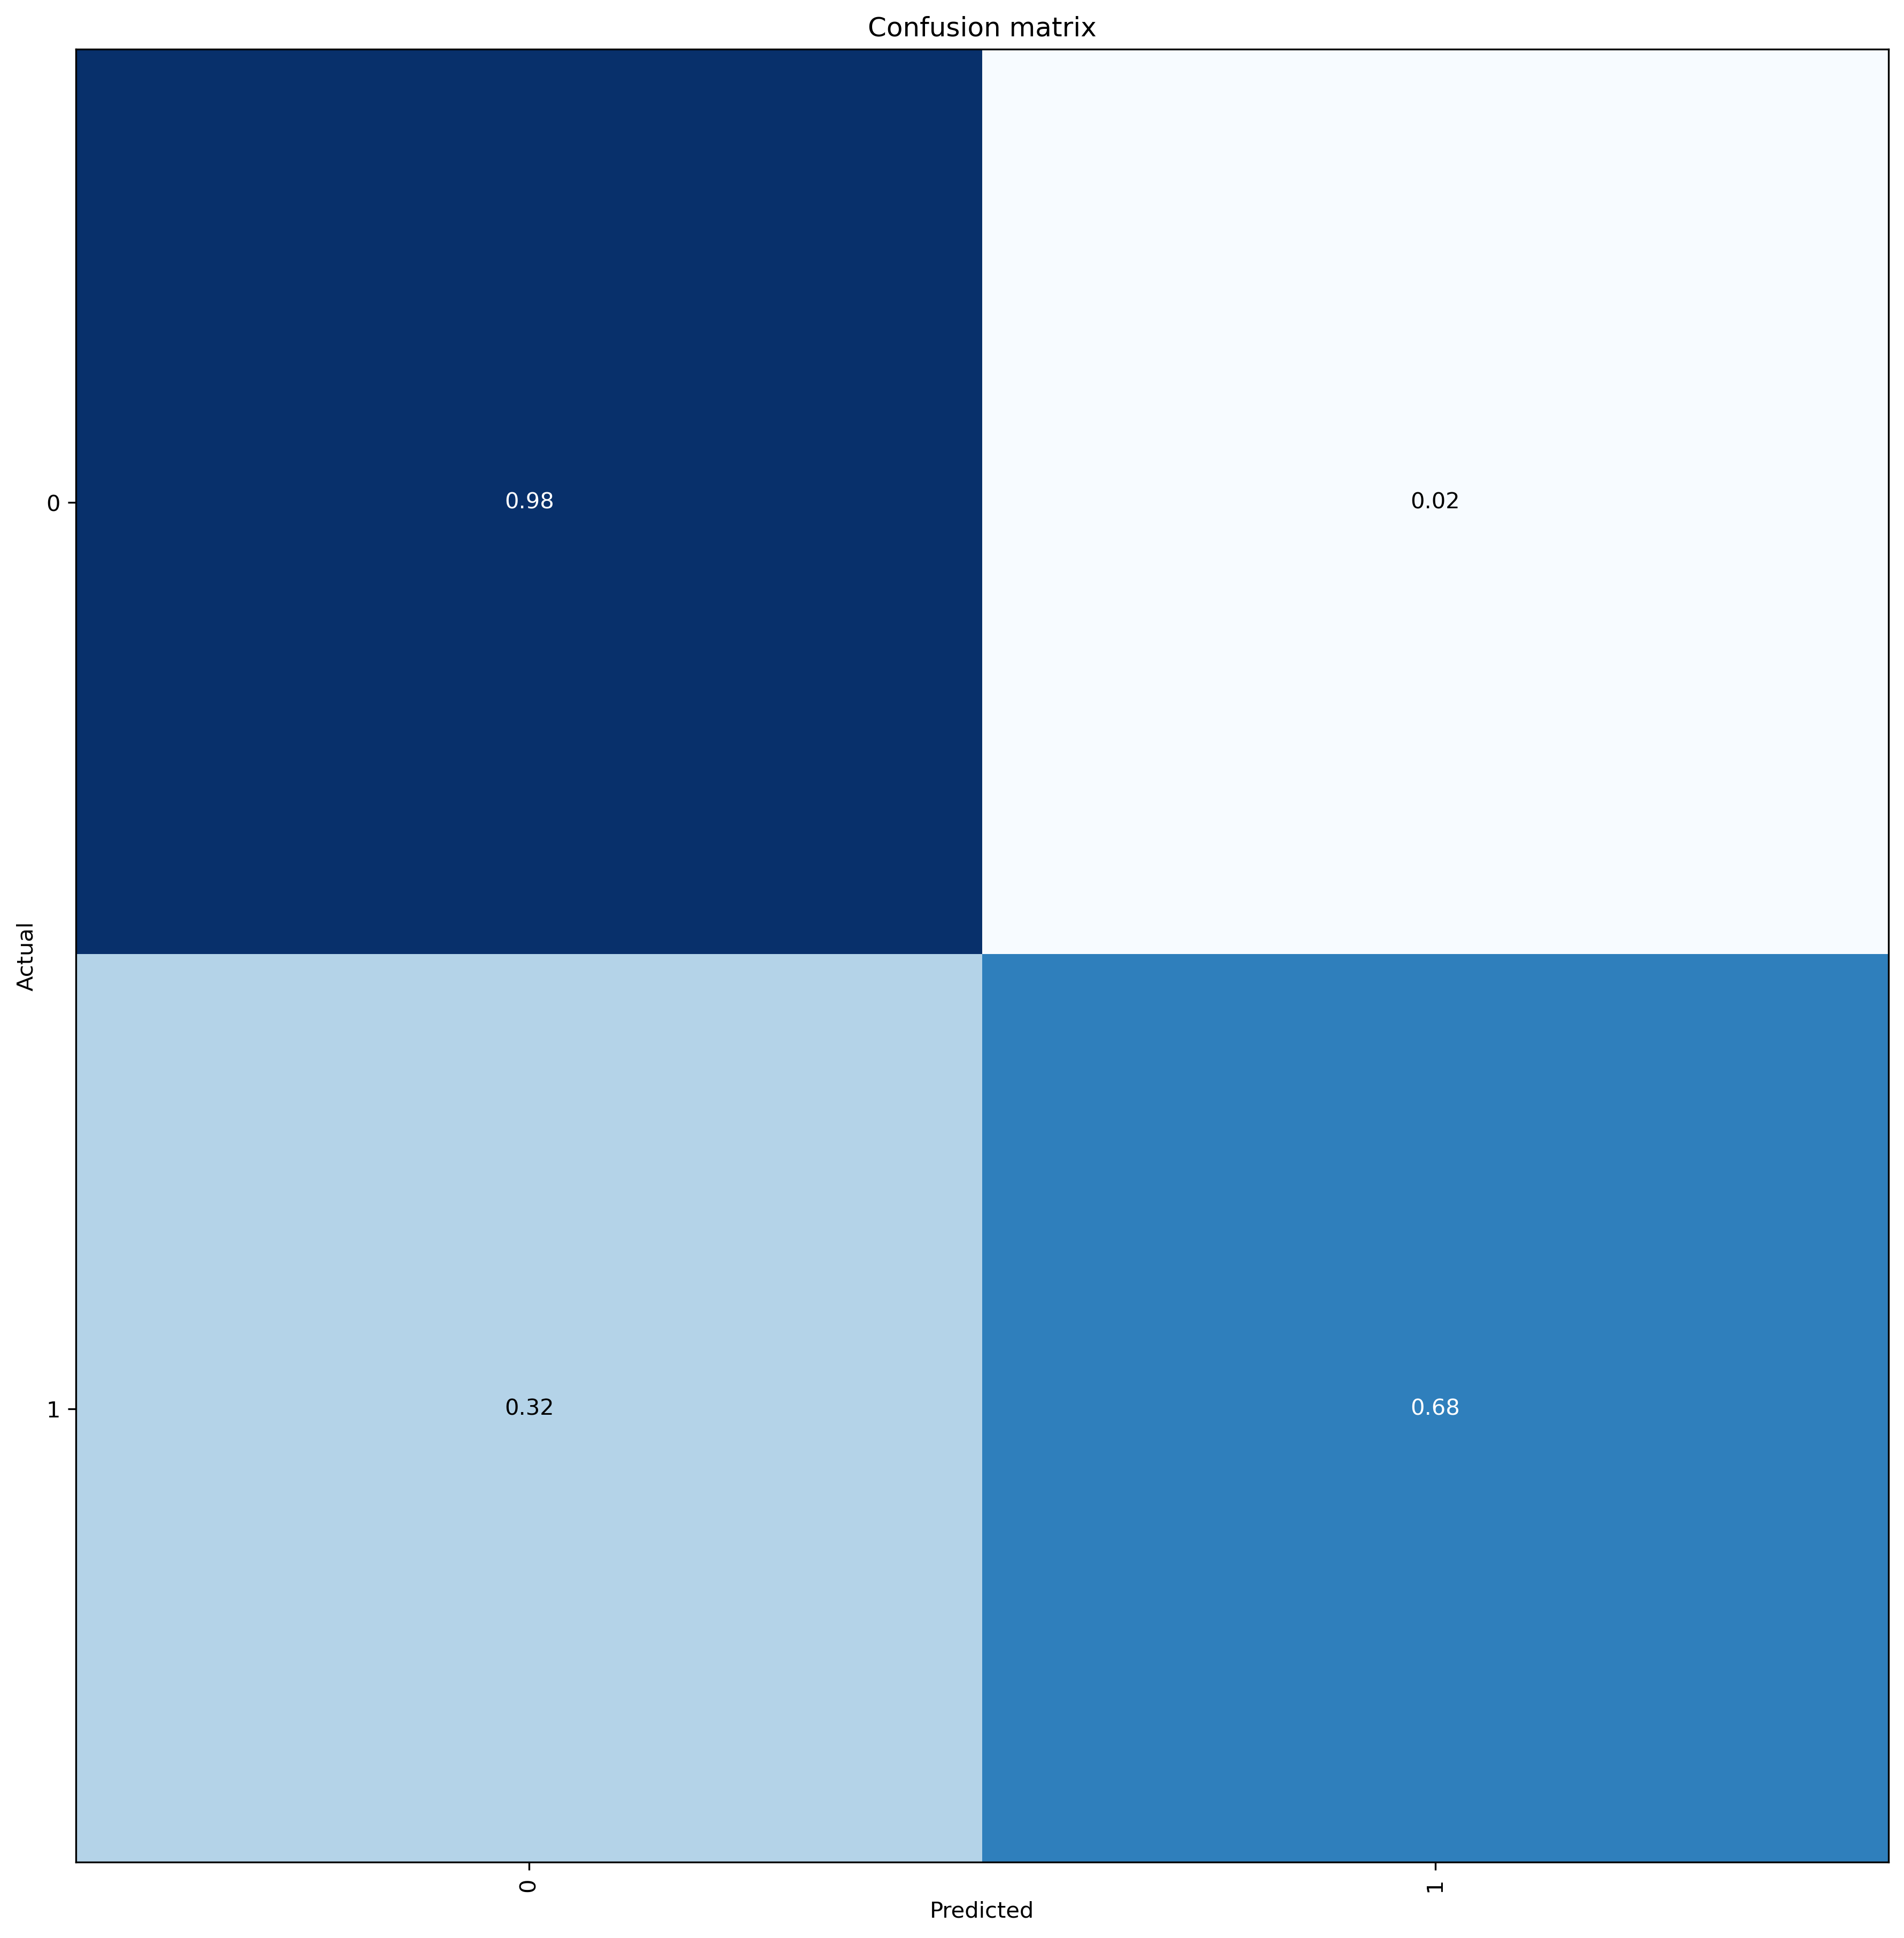

In [118]:
interpretation_results_.plot_confusion_matrix(normalize=True)

In [119]:
preds_new, y_new, losses_new = learn_.get_preds(with_loss=True)

In [120]:
fastai_score_new = roc_auc_score(to_np(y_new), to_np(preds_new[:,1]))
fastai_score_new

0.959637867457172

## XGBoost

In [121]:
n_estimators = 100
max_depth = 8
learning_rate = 0.1
subsample = 0.5

In [122]:
X_train_xgb_, y_train_xgb_ = to_train_.train.xs, to_train_.train.ys.values.ravel()
X_valid_xgb_, y_valid_xgb_ = to_train_.valid.xs, to_train_.valid.ys.values.ravel()

model_ = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample)

In [123]:
X_train_xgb_

,PropertyField37,PersonalField9,PersonalField1,PersonalField2,...,GeographicField26B,GeographicField55A,GeographicField50A,GeographicField51A
QuoteNumber,,,,,,,,,
393191,2,2,2,2,...,0.370229,-0.889744,0.681011,-0.354098
260338,1,2,2,2,...,0.094360,0.688312,-0.830329,-0.187631
118136,2,3,2,2,...,-1.698794,0.688312,-1.166182,-1.186432
347398,2,3,2,2,...,0.094360,-0.013046,0.009305,-0.853499
283382,1,1,1,1,...,-1.147054,-0.714405,1.352718,-0.187631
...,...,...,...,...,...,...,...,...,...
235805,1,2,2,2,...,1.335774,-0.013046,-0.830329,1.976437
296823,1,2,2,2,...,-1.422924,-0.363725,0.513085,0.644703
315048,2,3,2,2,...,-1.698794,-0.714405,-0.998255,-0.520565


In [124]:
xgb_model_new = model_.fit(X_train_xgb_, y_train_xgb_)
xgb_preds_new = xgb_model_new.predict_proba(X_valid_xgb_)
xgb_preds_new

C:\Users\ML\.conda\envs\fastai\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([[0.9983608 , 0.00163917],
       [0.9976694 , 0.00233062],
       [0.86252594, 0.13747407],
       ...,
       [0.9414947 , 0.05850532],
       [0.9810893 , 0.01891073],
       [0.99691015, 0.00308984]], dtype=float32)

In [125]:
accuracy(tensor(xgb_preds_new), tensor(y_valid_xgb_))

TensorBase(0.9235)

In [126]:
xgboost_score_new = roc_auc_score(y_valid_xgb_, xgb_preds_new[:,1])
xgboost_score_new

0.9623332497122224

# Random forest

In [127]:
X_train_rf_ = X_train_xgb_
y_train_rf_ = y_train_xgb_
X_valid_rf_ = X_valid_xgb_
y_valid_rf_ = y_valid_xgb_

In [128]:
X_train_rf_

,PropertyField37,PersonalField9,PersonalField1,PersonalField2,...,GeographicField26B,GeographicField55A,GeographicField50A,GeographicField51A
QuoteNumber,,,,,,,,,
393191,2,2,2,2,...,0.370229,-0.889744,0.681011,-0.354098
260338,1,2,2,2,...,0.094360,0.688312,-0.830329,-0.187631
118136,2,3,2,2,...,-1.698794,0.688312,-1.166182,-1.186432
347398,2,3,2,2,...,0.094360,-0.013046,0.009305,-0.853499
283382,1,1,1,1,...,-1.147054,-0.714405,1.352718,-0.187631
...,...,...,...,...,...,...,...,...,...
235805,1,2,2,2,...,1.335774,-0.013046,-0.830329,1.976437
296823,1,2,2,2,...,-1.422924,-0.363725,0.513085,0.644703
315048,2,3,2,2,...,-1.698794,-0.714405,-0.998255,-0.520565


In [129]:
rfc_new = RandomForestClassifier(n_estimators=100)
rfc_new.fit(X_train_rf_,y_train_rf_)

RandomForestClassifier()

In [130]:
rf_preds_new = rfc_new.predict_proba(X_valid_rf_)

In [131]:
rf_score_new = roc_auc_score(y_valid_rf_, rf_preds_new[:,1])
rf_score_new

0.9554955681428958

# Results

In [132]:
fastai_score, fastai_score_new

(0.9600280084385965, 0.959637867457172)

In [133]:
xgboost_score, xgboost_score_new

(0.9628106816192457, 0.9623332497122224)

In [134]:
rf_score, rf_score_new

(0.9531100126071104, 0.9554955681428958)

In [135]:
send_tg_message('final results are ready')